# Re-level ROSETTA-ice gravity data

import the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
from antarctic_plots import fetch, regions, utils, maps
import pygmt
import numpy as np
import pandas as pd
import numpy as np
from scipy import stats
import geopandas as gpd
import xarray as xr
import rioxarray
import verde as vd
import harmonica as hm
from pyproj import Transformer
import os
import zarr
import math
import scipy
import warnings
from tqdm.auto import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from RIS_gravity_inversion import gravity_processing as grav
from RIS_gravity_inversion import utils as inv_utils

os.getcwd()

'/Users/home/tankerma/RIS_gravity_inversion/notebooks/Ross_Ice_Shelf_inversion'

## load data
with antarctic_plots.fetch

                line       LATITUDE      LONGITUDE      unixtime  \
count  398279.000000  398279.000000  398279.000000  3.982790e+05   
mean      661.219550     -80.571198     -36.741857  1.457515e+09   
std       264.422153       1.786949     165.241996  1.431469e+07   
min        20.000000     -85.389220    -179.999880  1.447367e+09   
25%       470.000000     -81.869075    -169.885715  1.448316e+09   
50%       650.000000     -80.392556    -158.359371  1.449134e+09   
75%       840.000000     -79.145016     171.037900  1.479949e+09   
max      1140.000000     -77.339971     180.000724  1.480734e+09   

              Height        easting      northing   FAG_levelled  
count  398279.000000  398279.000000  3.982790e+05  398279.000000  
mean      793.056619  -84278.810943 -1.000705e+06     -40.834964  
std        83.977581  212966.781186  1.984653e+05      14.254793  
min       650.023000 -571781.809097 -1.367767e+06    -326.330214  
25%       744.524000 -240585.860838 -1.160510e+06   

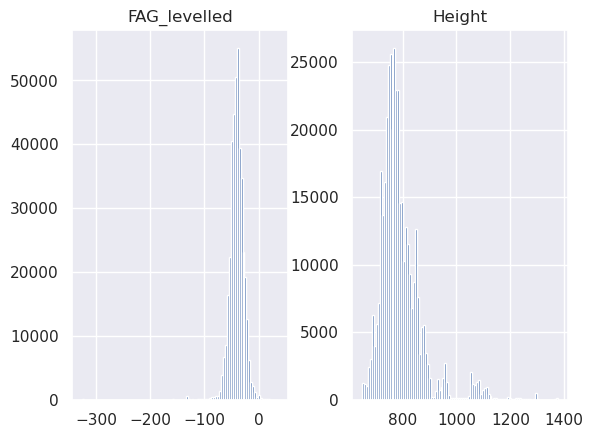

In [2]:
rosetta = fetch.ROSETTA_gravity()

# set standard column names
rosetta = rosetta.rename(columns={"Line": "line", "x": "easting", "y": "northing"})

rosetta = gpd.GeoDataFrame(
    rosetta,
    geometry=gpd.points_from_xy(x=rosetta.easting, y=rosetta.northing),
    crs="EPSG:3031",
)

rosetta[["FAG_levelled", "Height"]].hist(bins=100)
print(rosetta.describe())

In [3]:
# seperate e-w flight lines from n-s tie lines
ties = rosetta[rosetta.line >= 1000]
lines = rosetta[rosetta.line < 1000]

In [ ]:
grav.plotly_points(
    rosetta,
    # color_col="intersecting_line",
    color_col="Height",
    hover_cols=["line", "unixtime"],
    robust=True,
    # point_size=5,
)

Plot as point data

In [4]:
# get bounding region of data
# region = vd.get_region((rosetta.x, rosetta.y))
# # zoom out by 20 km
# region = utils.alter_region(region, zoom=-40e3)[0]
# # round to nearest 5km
# region = round_region(region, 5e3)
# region
region = (-620000.0, 460000.0, -1460000.0, -380000.0)

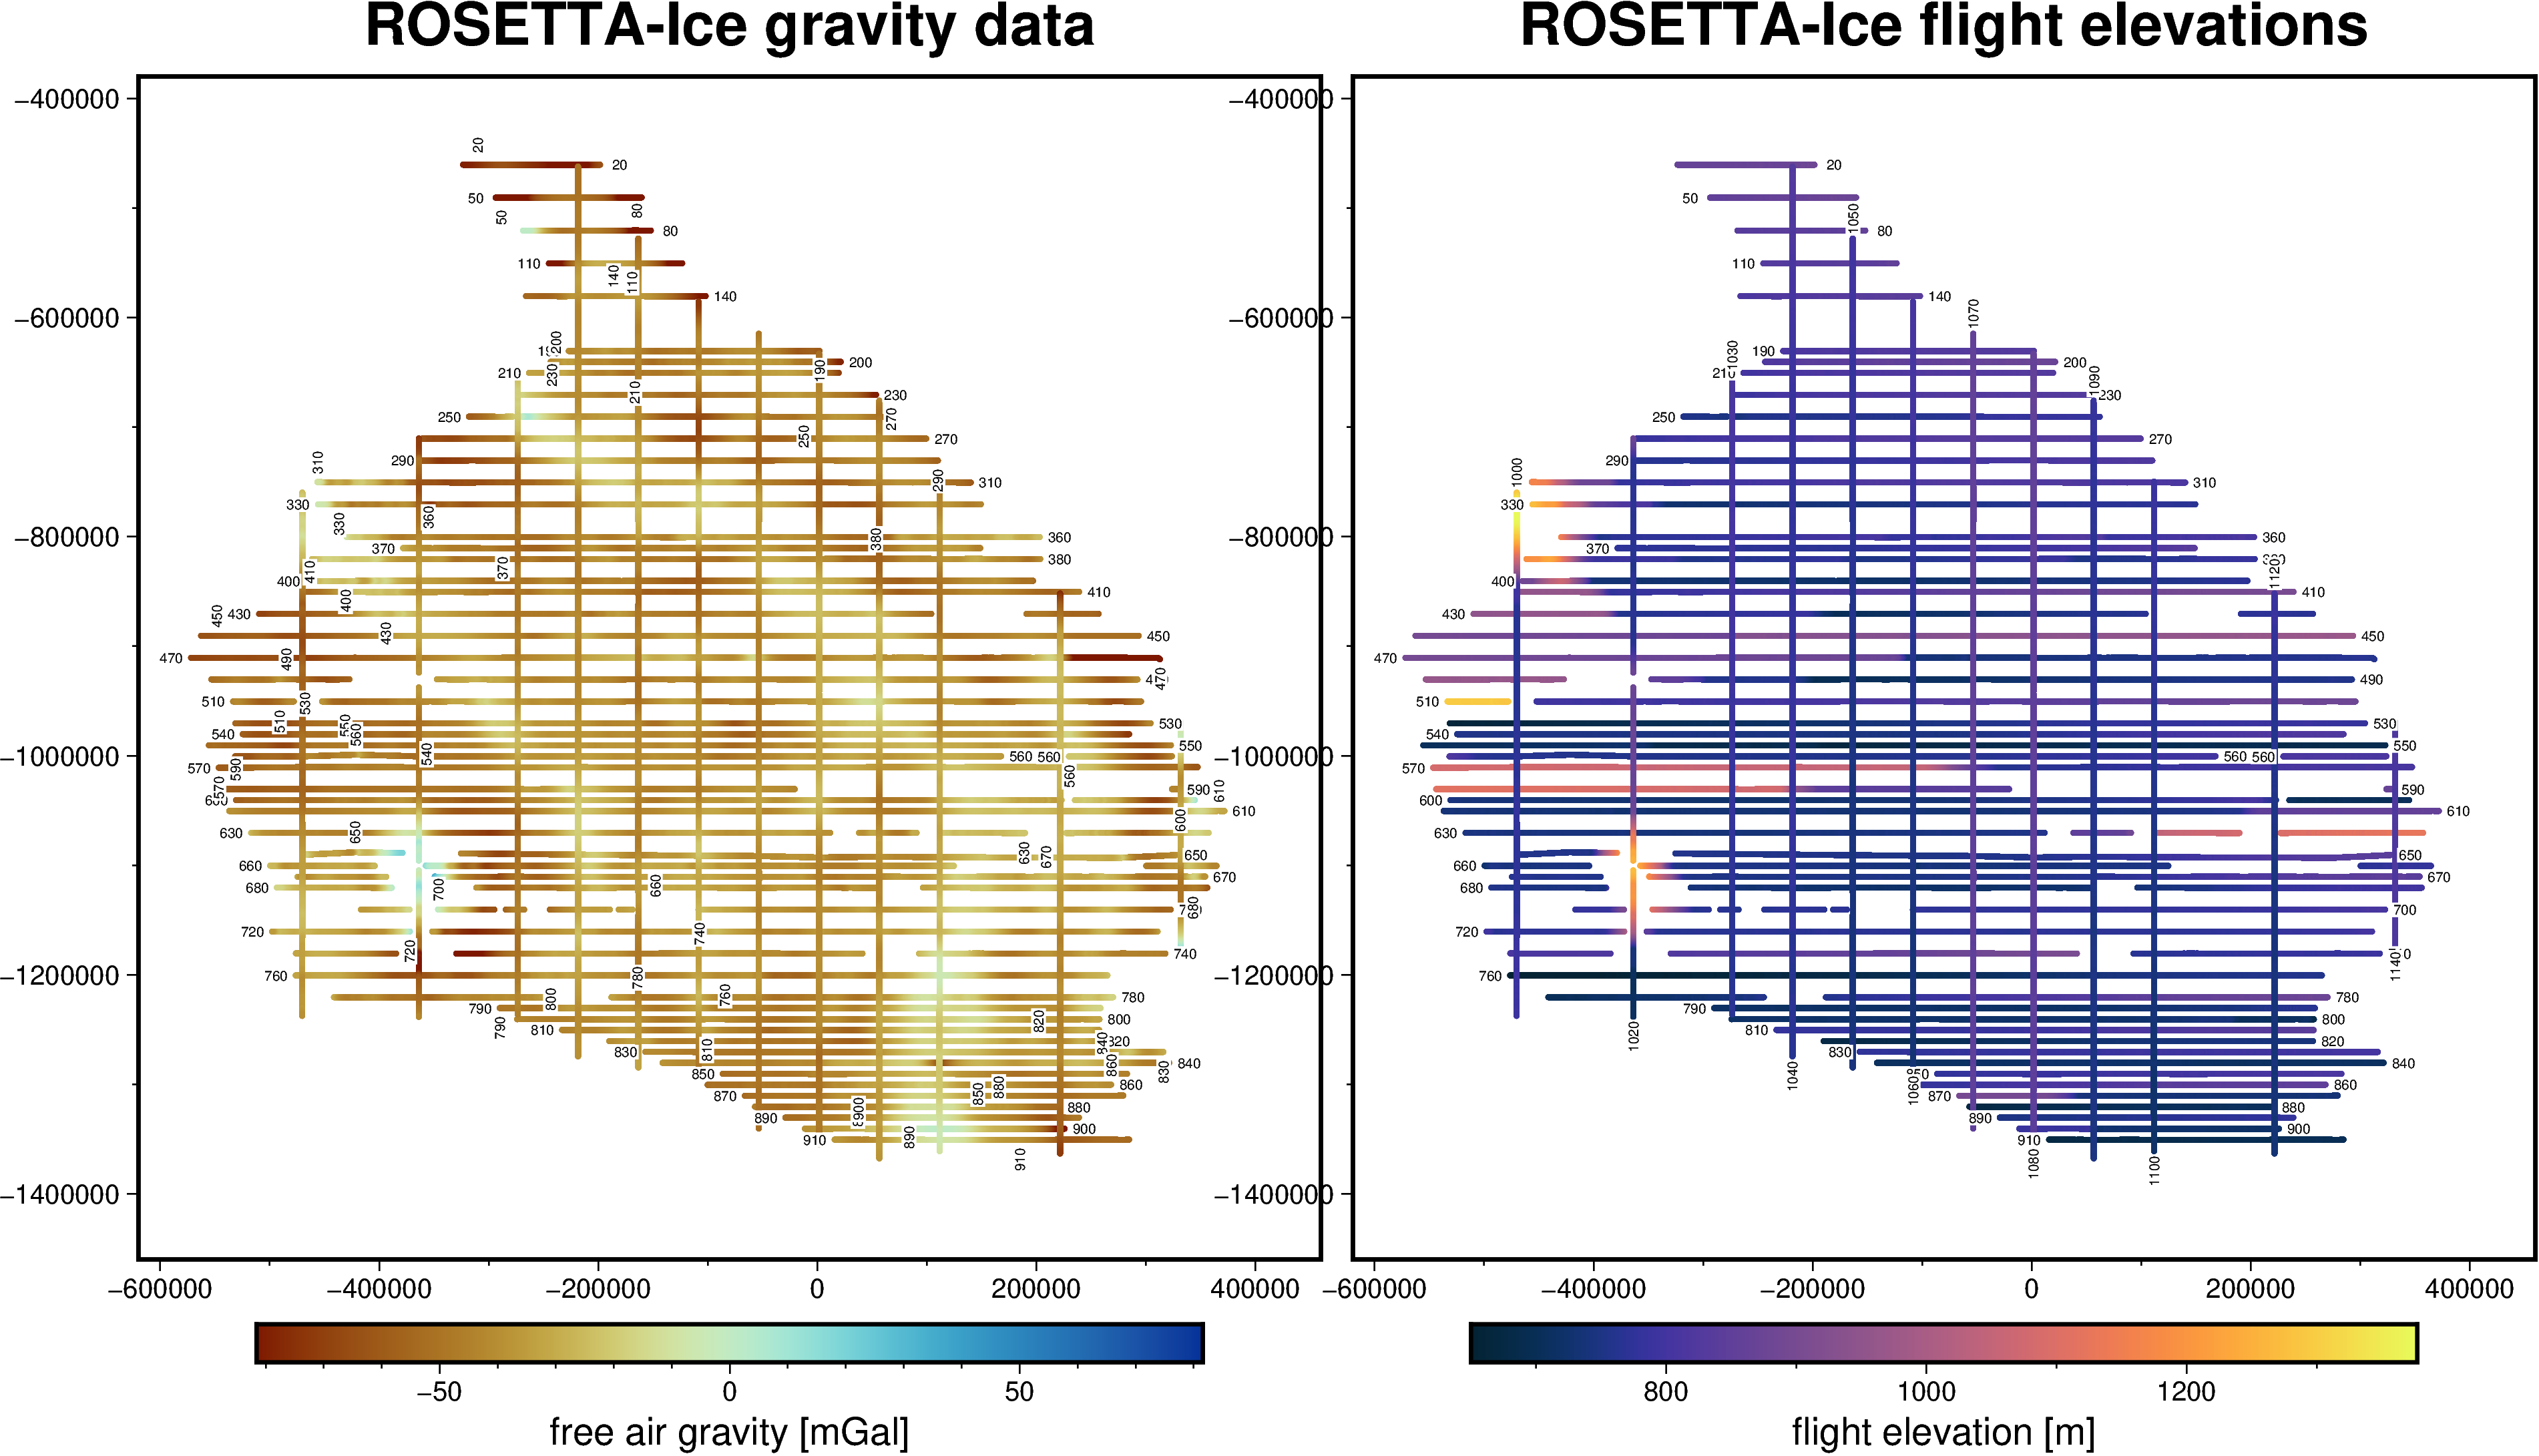

In [7]:
# plot a basemap
fig = maps.basemap(
    region,
    title="ROSETTA-Ice gravity data",
    background="black",
    frame=True,
)

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(rosetta.FAG_levelled) * 0.25
pygmt.makecpt(cmap="roma", series=[-maxabs, maxabs])

# plot gravity data
fig.plot(x=rosetta.easting, y=rosetta.northing, color=rosetta.FAG_levelled, style="c2p", cmap=True)

grav.plot_flightlines(fig, lines, plot_lines=False, direction="EW")

grav.plot_flightlines(fig, lines, plot_lines=False, direction="NS")

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')

# add a second figure to the right
fig = maps.basemap(
    region,
    title="ROSETTA-Ice flight elevations",
    origin_shift="xshift",
    fig=fig,
    background="black",
    frame=True,
)

# make a colorscale for flight elevations
pygmt.makecpt(cmap="thermal", series=[rosetta.Height.min(), rosetta.Height.max()])

# plot flight elevation data
fig.plot(x=rosetta.easting, y=rosetta.northing, color=rosetta.Height, style="c2p", cmap=True)

grav.plot_flightlines(fig, lines, plot_lines=False, direction="EW")
grav.plot_flightlines(fig, ties, plot_lines=False, direction="NS")

# plot the colorbar
fig.colorbar(frame='af+l"flight elevation [m]"')

fig.show()

# Intersections
create an intersections dataframe between all lines

In [ ]:
# !!! ONLY MAKES INTERSECTION WITHIN LINE, IF REAL INT IS JUST OUTSIDE END OF LINE
# IT WON'T COUNT. SHOULD BUFFER LINES BY DISTANCE.

# buffer dist extends line ends to include crossovers, in this case, T1040 would intersect with
# L20 if it were just 2 km longer.
inters = grav.create_intersection_table(
    rosetta,
    # cutoff_dist=20e3,
    plot=True,
    exclude_ints=[
        # [470, 1070],
        # [1120], # exclude all of 1120 since its causing issues
    ],
)
inters.describe()

In [ ]:
# add empty rows at each intersection to the grav df
rosetta, inters = grav.add_intersections(rosetta, inters)
rosetta[rosetta.is_intersection]

In [ ]:
inters.sort_values(by=["line1", "line2"])

In [ ]:
grav.plotly_points(
    rosetta,
    # color_col="intersecting_line",
    color_col="FAG_levelled",
    hover_cols=["line", "dist_along_line", "unixtime"],
    robust=True,
    # point_size=5,
)

In [ ]:
# x = grav.interp1d(
#     rosetta[rosetta.line.isin([1000])],
#     to_interp=["FAG_levelled", "Height"],

#     # interp_on=["x","y"],
#     # engine="verde",
#     # method=vd.Spline(),

#     interp_on="dist_along_line",
#     engine="scipy",
#     method="cubic",

#     # plot_line=True,
# )

# # x[x.is_intersection]

In [ ]:
# x = grav.interp1d_windows(
#     rosetta[rosetta.line.isin([1000])],
#     to_interp=["FAG_levelled", "Height"],

#     window_width = 1e3,

#     # interp_on=["x","y"],
#     # engine="verde",
#     # method=vd.Spline(),

#     interp_on="dist_along_line",
#     engine="scipy",
#     method="cubic",

#     # plot_windows=True,
#     # plot_line=True,
# )

# # x[x.is_intersection]

## Interpolate data at intersections

In [ ]:
rosetta = grav.interp1d_all_lines(
    rosetta,
    to_interp=["FAG_levelled", "Height"],
    window_width=5e3,
    # interp_on=["x","y"],
    # engine="verde",
    # method=vd.Spline(),
    interp_on="dist_along_line",
    engine="scipy",
    method="cubic",
    # plot=True,
    # wait_for_input=True,
)

## Save / load from csv

In [ ]:
print(rosetta.crs)
type(rosetta)

In [ ]:
rosetta.to_file("../../data/ROSETTA_data_before_UC.gpkg")
inters.to_file(
    "../../data/ROSETTA_intersections_before_UC.gpkg",
)

In [ ]:
rosetta = gpd.GeoDataFrame.from_file("../../data/ROSETTA_data_before_UC.gpkg")
inters = gpd.GeoDataFrame.from_file(
    "../../data/ROSETTA_intersections_before_UC.gpkg",
)
print(rosetta.crs)
type(rosetta)

## Manually check and clean data
set `plot=True` and `wait_for_input=True` in the above call to the function `grav.interp1d_all_lines`. This will give a plot for each flight line. Manually inspect each one, and add lines with issues to the below cell.

In [ ]:
lines_with_no_intersections = [
    20,
    560.0,
]
lines_with_int_issues = [
    250,  # gap at 1030
    430,  # gap at 1100
    470,  # iterpolated grav at 1050, 1040, and 1030
    510,  # gap at 1000
    630,  # gap at 1100, 1120
    660,  # gap at 1020
    680,  # gap at 1090 # might be close enough
    700,  # gap at 1020, 1050
    720,  # gap at 1020
    1020,  # gap at 660,
]
intersection_issues = [
    [250, 1300],
    [430, 1100],
    # [470, 1030],
    [470, 1040],
    # [470, 1050],
    [510, 1000],
    [630, 1100],
    [630, 1120],
    [660, 1020],
    [680, 1090],
    [700, 1020],
    [700, 1050],
    [720, 1020],
    [840, 1100],
    [1020, 660],
]

lines_with_elev_issues = [
    590,  # short chunk of data at start
]
lines_with_grav_issues = [
    450,  # flat at both ends
    470,  # flat at start, flat between ints of 1050 and 1030, very negative at start
    590,  # short chunk of data at start
    840,  # low at int with 1100
    870,  # flat at end
    900,  # flat at start
    910,  # flat at start
    1040,  # flat at start
    1070,  # flat at end
    1120,  # very negative at start
    1140,  # very positive at start
]

In [ ]:
grav.plotly_points(
    rosetta,
    coord_names=["easting", "northing"],
    color_col="FAG_levelled",
    hover_cols=["FAG_levelled", "Height", "line"],
    robust=True,
    # point_size=5,
)

In [ ]:
grav.plot_line_and_crosses(
    rosetta,
    line=830,
    y=["FAG_levelled", "Height"],
    y_axes=[1, 2],
)

In [ ]:
grav.plot_line_and_crosses(
    rosetta,
    line=470,
    y=["FAG_levelled", "Height"],
    y_axes=[1, 2],
)

In [ ]:
grav.plot_line_and_crosses(
    rosetta,
    line=1120,
    y=["FAG_levelled", "Height"],
    y_axes=[1, 2],
)

In [ ]:
df = rosetta.copy()
to_remove = []

# 450: delete flat grav data at start
clean = df.loc[
    (df.line == 450) & ((df.dist_along_line < 6e3) | (df.dist_along_line > 802e3))
]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 470: delete flat grav data at start and anomalously low values and flat data between ints 1030 and 1050
clean = df.loc[
    (df.line == 470)
    & ((df.dist_along_line < 90e3) | (df.dist_along_line.between(476.5e3, 585.5e3)))
]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 590: delete grav + height data at start
clean = df.loc[(df.line == 590) & (df.dist_along_line < 10e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 650: delete grav + height data after Roosevelt Island (too high)
clean = df.loc[(df.line == 650) & (df.dist_along_line > 700e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 830: delete grav + height at beginning (maybe a false anomaly?)
clean = df.loc[(df.line == 830) & (df.dist_along_line < 69e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 840: delete grav low between 228k - 294k at int with 1100
clean = df.loc[(df.line == 840) & (df.dist_along_line.between(228e3, 294e3))]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 870: delete grav + height data at end
clean = df.loc[(df.line == 870) & (df.dist_along_line > 315e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 890: delete grav + height data at start
clean = df.loc[(df.line == 890) & (df.dist_along_line < 13e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 900: delete grav + height data at start
clean = df.loc[(df.line == 900) & (df.dist_along_line < 3.8e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 910: delete grav + height data at start
clean = df.loc[(df.line == 910) & (df.dist_along_line < 26e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 1040: delete grav + height data at start
clean = df.loc[(df.line == 1040) & (df.dist_along_line < 27e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

# 1070: delete grav + height data at end, removes intersection with 880
clean = df.loc[(df.line == 1070) & (df.dist_along_line > 700e3)]
print(f"removing {len(clean)} points from line {clean.line.unique()}")
to_remove.append(clean)

df_remove = pd.concat(to_remove)

rosetta_cleaned = rosetta.drop(index=df_remove.index)
assert len(rosetta_cleaned) == len(rosetta) - len(df_remove)

print(f"\ntotal number of rows in dataframe: {len(rosetta_cleaned)}")

In [ ]:
print(
    f"number of intersections in dataframe: {len(rosetta_cleaned[rosetta_cleaned.is_intersection])}"
)
print(f"number of intersections: {len(inters)}")

In [ ]:
# plot a basemap
fig = maps.basemap(
    region=vd.pad_region(vd.get_region((rosetta.easting, rosetta.northing)), 20e3),
    frame=True,
    # background="black",
)

# plot gravity data
fig.plot(
    x=rosetta.easting,
    y=rosetta.northing,
    style="c6p",
    fill="black",
    label="original data",
)

# plot gravity data
fig.plot(
    x=rosetta_cleaned.easting,
    y=rosetta_cleaned.northing,
    style="c2p",
    fill="magenta",
    label="manually cleaned data",
)

fig.legend()
fig.show()

## Re-do intersections with cleaned data

In [ ]:
inters = grav.create_intersection_table(
    rosetta_cleaned,
    # cutoff_dist=20e3,
    exclude_ints=[
        # [470, 1070],
        # [1120], # exclude all of 1120 since its causing issues
    ],
    plot=False,
)
rosetta_df, inters = grav.add_intersections(rosetta_cleaned, inters)

print(
    f"number of intersections in dataframe: {len(rosetta_df[rosetta_df.is_intersection])}"
)
print(f"number of intersections: {len(inters)}")

## Re-interpolate at new intersections

In [ ]:
rosetta_df = grav.interp1d_all_lines(
    rosetta_df,
    to_interp=["FAG_levelled", "Height"],
    window_width=5e3,
    interp_on="dist_along_line",
    engine="scipy",
    method="cubic",
    # plot=True,
    # wait_for_input=True,
)
rosetta_df[rosetta_df.is_intersection]

##  Get crossover errors

https://gist.github.com/maptastik/dc3d3b4514546310500a13fb77663bb9


In [ ]:
inters, rosetta_df = grav.calculate_misties(
    inters,
    rosetta_df,
    data_col="FAG_levelled",
    mistie_name="mistie_before_UC",
    # plot=True,
    robust=False,
)
print(f"mistie RMS: {utils.RMSE(inters.mistie_before_UC)}mGal")
inters.sort_values(by="mistie_before_UC")

## Save / load from csv

In [ ]:
rosetta_df.to_csv(
    "../../data/ROSETTA_cleaned.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
inters.to_file(
    "../../data/ROSETTA_cleaned_intersections.gpkg",
)

In [12]:
rosetta_df = pd.read_csv(
    "../../data/ROSETTA_cleaned.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inters = gpd.GeoDataFrame.from_file(
    "../../data/ROSETTA_cleaned_intersections.gpkg",
)
rosetta_df.describe()

,line,LATITUDE,LONGITUDE,unixtime,Height,easting,northing,FAG_levelled,intersecting_line,dist_along_line,mistie_before_UC
count,392665.000000,391797.000000,391797.000000,3.917970e+05,392665.000000,392665.000000,3.926650e+05,392665.000000,868.000000,392665.000000,868.000000
mean,661.296327,-80.582793,-37.731744,1.457218e+09,792.718891,-86003.867050,-9.996115e+05,-40.674264,816.256912,326695.387544,0.666057
std,265.439146,1.782601,165.071979,1.416613e+07,83.863497,211336.255947,1.979675e+05,13.662769,285.718138,220283.512547,5.461298
min,20.000000,-85.389220,-179.999880,1.447367e+09,650.023000,-571781.809097,-1.367767e+06,-326.330214,50.000000,0.000000,-32.073100
25%,470.000000,-81.902383,-170.004771,1.448316e+09,744.443000,-241141.189235,-1.160505e+06,-48.113560,570.000000,139264.894847,-1.754538
50%,630.000000,-80.396924,-158.495897,1.449131e+09,774.601000,-80354.532432,-1.010413e+06,-40.610241,955.000000,297922.751583,0.254597
75%,850.000000,-79.159686,171.146777,1.479947e+09,819.289000,76185.914486,-8.504349e+05,-32.887337,1070.000000,489554.898121,1.945501
max,1140.000000,-77.339971,180.000724,1.480734e+09,1377.258000,371757.426732,-4.604543e+05,36.478854,1140.000000,908716.753527,43.436215


In [ ]:
from scipy import stats

stats.percentileofscore(rosetta_df.Height, 1000)

In [ ]:
rosetta_df.Height.plot.hist(bins=100)

In [ ]:
rosetta_df.FAG_levelled.plot.hist(bins=100)

# Individually block-reduce lines

In [ ]:
grouped = rosetta_df.groupby("line")

blocked_dfs = []
for name, group in grouped:
    df = group.drop(columns="geometry")

    blocked = utils.block_reduce(
        df.drop(columns=["is_intersection", "intersecting_line"]),
        np.mean,
        spacing=1e3,
        center_coordinates=False,
        input_coord_names=["easting", "northing"],
    )

    # add back columns
    blocked["is_intersection"] = False
    blocked["intersecting_line"] = ""

    # merge back intersection points
    prior_len = len(blocked)
    blocked = pd.concat([blocked, df[df.is_intersection]])
    assert len(blocked) == prior_len + len(df[df.is_intersection])

    blocked_dfs.append(blocked)

rosetta_blocked = pd.concat(blocked_dfs)
rosetta_blocked

In [ ]:
rosetta_blocked[rosetta_blocked.is_intersection]

## Save / load from csv

In [ ]:
rosetta_blocked.to_csv(
    "../../data/ROSETTA_cleaned_blocked.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [5]:
rosetta_blocked = pd.read_csv(
    "../../data/ROSETTA_cleaned_blocked.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
rosetta_blocked

,easting,northing,line,LATITUDE,LONGITUDE,unixtime,Height,FAG_levelled,dist_along_line,mistie_before_UC,is_intersection,intersecting_line
0,-323017.301127,-4.604725e+05,20.0,-84.827798,-144.950697,1.480724e+09,864.253917,-79.585185,124715.592483,NaN,False,NaN
1,-321997.009961,-4.604783e+05,20.0,-84.833130,-145.036205,1.480724e+09,863.984667,-79.477289,123695.301723,NaN,False,NaN
2,-320976.263358,-4.604806e+05,20.0,-84.838479,-145.121727,1.480724e+09,864.379083,-79.280965,122674.555360,NaN,False,NaN
3,-319954.356535,-4.604793e+05,20.0,-84.843849,-145.207317,1.480724e+09,864.349250,-79.010975,121652.648406,NaN,False,NaN
4,-318974.502480,-4.604769e+05,20.0,-84.848997,-145.289477,1.480724e+09,864.732182,-78.693828,120672.794120,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
37827,331826.687432,-1.100608e+06,1140.0,NaN,NaN,NaN,817.359125,-41.511223,74254.443110,5.295003,True,660.0
37828,331826.259411,-1.070505e+06,1140.0,NaN,NaN,NaN,818.293178,-31.341988,104357.487900,1.763079,True,630.0
37829,331840.937091,-1.050564e+06,1140.0,NaN,NaN,NaN,821.552383,-32.080697,124298.192629,1.681957,True,610.0
37830,331832.763929,-1.040655e+06,1140.0,NaN,NaN,NaN,819.200242,-33.006908,134206.942814,4.427681,True,600.0


In [7]:
grav.plotly_points(
    rosetta_blocked,
    coord_names=["easting", "northing"],
    color_col="FAG_levelled",
    hover_cols=["FAG_levelled", "Height", "line"],
    robust=True,
    # point_size=4,
)

In [ ]:
grav.plotly_points(
    rosetta_blocked,
    coord_names=["easting", "northing"],
    color_col="Height",
    hover_cols=["FAG_levelled", "Height", "line"],
    robust=True,
    # point_size=5,
)

# Individually upward continue lines

## find optimal parameters for each line

In [8]:
df = rosetta_blocked.copy()
lines = df.groupby("line")

damping_limits = [1, 500]
depth_limits = [0, 20e3]

best_dampings = []
best_depths = []
eqs_bests = []
line_names = []
scores = []
for line, df in tqdm(lines, desc="Lines"):
    coords = (df.easting, df.northing, df.Height)
    data = df.FAG_levelled

    study_df, eqs = inv_utils.optimize_eq_source_params(
        coords,
        data,
        n_trials=10,
        damping_limits=damping_limits,
        depth_limits=depth_limits,
        parallel=False,
        # fname="tmp",
        # use_existing=True,
        plot=False,
    )

    # get best score
    score = study_df.iloc[0].value

    # add values to lists
    best_dampings.append(eqs.damping)
    best_depths.append(eqs.depth)
    eqs_bests.append(eqs)
    line_names.append(line)
    scores.append(score)

best_eqs_per_line = pd.DataFrame(
    {
        "line": line_names,
        "eq_fitted": eqs_bests,
        "damping": best_dampings,
        "depth": best_depths,
        "score": scores,
    }
)

best_eqs_per_line.to_pickle("../../data/RIS_best_eqs_per_line.pkl")

best_eqs_per_line = pd.read_pickle(
    "../../data/RIS_best_eqs_per_line.pkl",
)

print(
    f"Dampings: possible range: {damping_limits[0], damping_limits[1]}\n",
    f"  min: {np.min(best_eqs_per_line.damping)}\n",
    f"  mode: {best_eqs_per_line.damping.mode()[0]}\n",
    f"  max: {np.max(best_eqs_per_line.damping)}",
)
print(
    f"Depths: possible range: {depth_limits[0], depth_limits[1]}\n",
    f"  min: {np.min(best_eqs_per_line.depth)}\n",
    f"  mode: {best_eqs_per_line.depth.mode()[0]}\n",
    f"  max: {np.max(best_eqs_per_line.depth)}",
)
best_eqs_per_line

Lines:   0%|          | 0/68 [00:00<?, ?it/s]

[I 2023-06-06 18:36:44,240] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 42.36848942010978, 'depth': 10914.254960692582}
Best trial: 4
Best score: 0.9649059434811564


[I 2023-06-06 18:36:52,404] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:36:57,777] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 25.55245007202849, 'depth': 9326.859580081402}
Best trial: 5
Best score: 0.9887025403264472


[I 2023-06-06 18:37:03,320] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 19.745622247024706, 'depth': 13712.12370960109}
Best trial: 2
Best score: 0.9901652725901993
Best params: {'damping': 68.19765050438318, 'depth': 1761.364478979426}
Best trial: 3
Best score: 0.9326996961070616


[I 2023-06-06 18:37:08,396] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:37:13,324] A new study created in Journal with name: tmp


Best params: {'damping': 31.178444660086384, 'depth': 15340.894451843782}
Best trial: 6
Best score: 0.9871548286841971


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 36.00639878035836, 'depth': 16706.72058765255}
Best trial: 0
Best score: 0.9712533276656263


[I 2023-06-06 18:37:19,473] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:37:27,353] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 2.405488849960788, 'depth': 5114.234375883009}
Best trial: 0
Best score: 0.9841004173701429


[I 2023-06-06 18:37:36,006] A new study created in Journal with name: tmp


Best params: {'damping': 170.04516650332386, 'depth': 9253.780652272724}
Best trial: 0
Best score: 0.9112681579432698


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 50.94499240814873, 'depth': 7865.480608206143}
Best trial: 8
Best score: 0.9869385611021253


[I 2023-06-06 18:37:44,690] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 14.660131982355546, 'depth': 5148.5825527988145}
Best trial: 9
Best score: 0.9939606066626938


[I 2023-06-06 18:37:52,005] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 77.39782314645737, 'depth': 15788.267708740997}
Best trial: 8
Best score: 0.9943630444417455


[I 2023-06-06 18:37:57,402] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 21.575440093863925, 'depth': 5996.061471090526}
Best trial: 0
Best score: 0.9978891651113828


[I 2023-06-06 18:38:03,440] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 79.14282758293284, 'depth': 8154.544589481437}
Best trial: 4
Best score: 0.990807942150995


[I 2023-06-06 18:38:09,377] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 22.29225700509033, 'depth': 2845.214912601695}
Best trial: 7
Best score: 0.9959703020445982


[I 2023-06-06 18:38:17,153] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 112.74667899890305, 'depth': 6709.928550761273}
Best trial: 5
Best score: 0.9917114312934704


[I 2023-06-06 18:38:26,654] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 31.134388637664703, 'depth': 6029.825472486245}
Best trial: 0
Best score: 0.9951938741397706


[I 2023-06-06 18:38:34,301] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 176.90815022954715, 'depth': 4485.651292765736}
Best trial: 4
Best score: 0.9927899065296348


[I 2023-06-06 18:38:42,731] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:38:50,006] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 245.3481092566134, 'depth': 3874.1610810931193}
Best trial: 6
Best score: 0.9885391908799596


[I 2023-06-06 18:38:56,417] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 21.010986116546913, 'depth': 5370.212699460464}
Best trial: 2
Best score: 0.9982344699497616


[I 2023-06-06 18:39:02,437] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 138.7151513348089, 'depth': 6128.699057052693}
Best trial: 6
Best score: 0.9905389888440247


[I 2023-06-06 18:39:08,024] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 15.399042625711925, 'depth': 9654.43337639861}
Best trial: 9
Best score: 0.9989765410973186


[I 2023-06-06 18:39:13,670] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 21.779577876984387, 'depth': 8002.969479426311}
Best trial: 2
Best score: 0.9979013091370517


[I 2023-06-06 18:39:19,875] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 79.20509499715924, 'depth': 10075.55586225579}
Best trial: 3
Best score: 0.9934053066412097
Best params: {'damping': 4.782756156532201, 'depth': 17327.1863902765}
Best trial: 8
Best score: 0.9939075115249197


[I 2023-06-06 18:39:26,824] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:39:33,335] A new study created in Journal with name: tmp


Best params: {'damping': 151.75255055000477, 'depth': 15947.152727463545}
Best trial: 0
Best score: 0.988392451527816


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:39:39,634] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 35.37126533939142, 'depth': 3751.101252376419}
Best trial: 0
Best score: 0.9979844840325913
Best params: {'damping': 39.59287657722662, 'depth': 10442.169199667926}
Best trial: 3
Best score: 0.9979517800118819


[I 2023-06-06 18:39:46,929] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 1.27113663726046, 'depth': 9430.557435786544}
Best trial: 8
Best score: 0.9997489293890652


[I 2023-06-06 18:39:55,755] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 32.95434415346831, 'depth': 5595.170197130079}
Best trial: 2
Best score: 0.994530870481688


[I 2023-06-06 18:40:06,789] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 136.83477473035117, 'depth': 6797.310192620187}
Best trial: 7
Best score: 0.9947599419308926


[I 2023-06-06 18:40:21,344] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:40:27,424] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 6.509628341095091, 'depth': 18304.353949416443}
Best trial: 2
Best score: 0.9971414205258776
Best params: {'damping': 1.3964868859906212, 'depth': 9123.551512829126}
Best trial: 5
Best score: 0.9987381209926115


[I 2023-06-06 18:40:34,104] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 19.679843469628935, 'depth': 13867.905887959536}
Best trial: 6
Best score: 0.999536548615859


[I 2023-06-06 18:40:43,228] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 73.44431321948404, 'depth': 7627.376559068799}
Best trial: 8
Best score: 0.9963531160811574


[I 2023-06-06 18:40:51,758] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 120.31798848066728, 'depth': 5336.213284986291}
Best trial: 1
Best score: 0.9944730909391792


[I 2023-06-06 18:40:57,427] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 70.69474830266606, 'depth': 3072.4879690827624}
Best trial: 2
Best score: 0.9931242861667112


[I 2023-06-06 18:41:02,916] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:41:08,837] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 75.62399150968521, 'depth': 14854.917942079746}
Best trial: 1
Best score: 0.972900437474998
Best params: {'damping': 38.77824568065861, 'depth': 9663.420448276105}
Best trial: 7
Best score: 0.9912035561122355


[I 2023-06-06 18:41:14,898] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:41:20,629] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 265.564834523977, 'depth': 3439.345011334625}
Best trial: 6
Best score: 0.9720024367540937


[I 2023-06-06 18:41:26,538] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 68.80083317722797, 'depth': 4234.717259829646}
Best trial: 5
Best score: 0.9948848853850821
Best params: {'damping': 32.63374835979826, 'depth': 15827.62670817564}
Best trial: 4
Best score: 0.9954798291126705


[I 2023-06-06 18:41:32,481] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:41:38,644] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 99.89941323216627, 'depth': 7382.084229398003}
Best trial: 2
Best score: 0.9978027102164579
Best params: {'damping': 98.76264791425052, 'depth': 3998.695980537943}
Best trial: 8
Best score: 0.9967344160237701


[I 2023-06-06 18:41:44,946] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 217.82907656119332, 'depth': 4516.694336332574}
Best trial: 8
Best score: 0.9947927099198445


[I 2023-06-06 18:41:52,493] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:41:58,877] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 105.68028397820687, 'depth': 7873.394752407632}
Best trial: 8
Best score: 0.9977371364988109
Best params: {'damping': 355.7811366260911, 'depth': 6757.306446441496}
Best trial: 4
Best score: 0.9861952012813461


[I 2023-06-06 18:42:04,841] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 41.67531994766052, 'depth': 13120.933277785405}
Best trial: 9
Best score: 0.9912303044532429


[I 2023-06-06 18:42:10,799] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:42:16,350] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 10.259900681401934, 'depth': 16936.988660507322}
Best trial: 2
Best score: 0.997739857156111


[I 2023-06-06 18:42:21,071] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 34.009983286494744, 'depth': 4552.633549201019}
Best trial: 0
Best score: 0.9963905563830165


[I 2023-06-06 18:42:26,815] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 63.72281598990775, 'depth': 16301.364964004872}
Best trial: 4
Best score: 0.9898589129845139


[I 2023-06-06 18:42:32,466] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 82.37745328820753, 'depth': 10686.688825956327}
Best trial: 5
Best score: 0.9878470426199459


[I 2023-06-06 18:42:37,645] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 64.01465719287992, 'depth': 19073.02766725284}
Best trial: 8
Best score: 0.9918039055371267


[I 2023-06-06 18:42:45,115] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 117.23191273863524, 'depth': 5349.545451098356}
Best trial: 4
Best score: 0.9933885595596192
Best params: {'damping': 3.1765226793298864, 'depth': 11804.685785757605}
Best trial: 7
Best score: 0.9994406575443362


[I 2023-06-06 18:42:52,527] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:42:59,737] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 22.947858585980104, 'depth': 4858.370530198875}
Best trial: 8
Best score: 0.9972550872016926


[I 2023-06-06 18:43:04,836] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 21.336706193609693, 'depth': 17720.16711954651}
Best trial: 1
Best score: 0.9988745726018033
Best params: {'damping': 1.3715853692998303, 'depth': 6191.347177464854}
Best trial: 9
Best score: 0.9990227739212333


[I 2023-06-06 18:43:11,315] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 8.37396910631519, 'depth': 2278.883205117366}
Best trial: 4
Best score: 0.9977032082503744


[I 2023-06-06 18:43:20,115] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 48.100230949398494, 'depth': 6003.294432924599}
Best trial: 2
Best score: 0.9970232983577254


[I 2023-06-06 18:43:30,244] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 14.830687022410611, 'depth': 6354.073088960244}
Best trial: 4
Best score: 0.9994397080575771


[I 2023-06-06 18:43:37,824] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:43:45,410] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 38.47565544046147, 'depth': 4403.770279511694}
Best trial: 8
Best score: 0.9958368072804481
Best params: {'damping': 51.11957129403232, 'depth': 5232.6948443216415}
Best trial: 1
Best score: 0.9966092900572882


[I 2023-06-06 18:43:51,447] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 161.03332232723736, 'depth': 8150.839053666213}
Best trial: 7
Best score: 0.9820889053465407


[I 2023-06-06 18:43:57,918] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-06 18:44:03,861] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 68.9411792796451, 'depth': 9889.374526621092}
Best trial: 0
Best score: 0.9967501469185926


[I 2023-06-06 18:44:09,601] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 39.2266446309604, 'depth': 2412.3651992068053}
Best trial: 9
Best score: 0.9965337724269672


[I 2023-06-06 18:44:15,566] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 44.30320109771549, 'depth': 8825.627223277628}
Best trial: 0
Best score: 0.9984687807268612


[I 2023-06-06 18:44:21,278] A new study created in Journal with name: tmp


Best params: {'damping': 33.641871582666525, 'depth': 7227.188417535497}
Best trial: 6
Best score: 0.9919645483161925


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 21.02519636090692, 'depth': 5324.695703780149}
Best trial: 8
Best score: 0.9945935247918569
Dampings: possible range: (1, 500)
   min: 1.27113663726046
   mode: 1.27113663726046
   max: 355.7811366260911
Depths: possible range: (0, 20000.0)
   min: 1761.364478979426
   mode: 1761.364478979426
   max: 19073.02766725284


,line,eq_fitted,damping,depth,score
0,20.0,"EquivalentSources(damping=42.36848942010978, d...",42.368489,10914.254961,0.964906
1,50.0,"EquivalentSources(damping=25.55245007202849, d...",25.552450,9326.859580,0.988703
2,80.0,"EquivalentSources(damping=19.745622247024706, ...",19.745622,13712.123710,0.990165
3,110.0,"EquivalentSources(damping=68.19765050438318, d...",68.197651,1761.364479,0.932700
4,140.0,"EquivalentSources(damping=31.178444660086384, ...",31.178445,15340.894452,0.987155
...,...,...,...,...,...
63,1080.0,"EquivalentSources(damping=68.9411792796451, de...",68.941179,9889.374527,0.996750
64,1090.0,"EquivalentSources(damping=39.2266446309604, de...",39.226645,2412.365199,0.996534
65,1100.0,"EquivalentSources(damping=44.30320109771549, d...",44.303201,8825.627223,0.998469
66,1120.0,"EquivalentSources(damping=33.641871582666525, ...",33.641872,7227.188418,0.991965


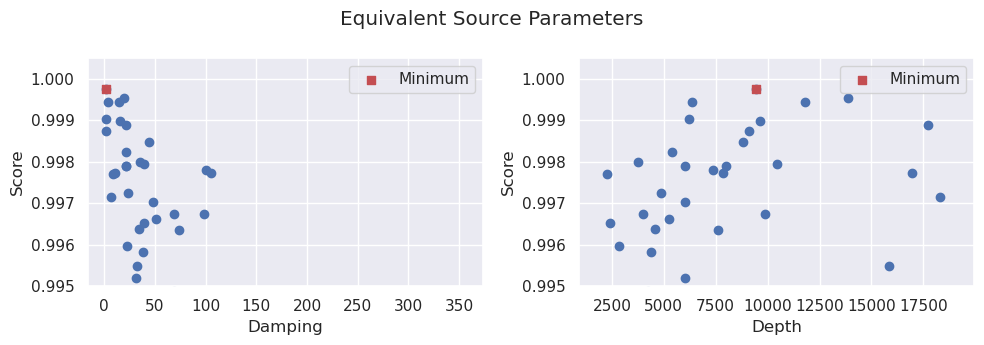

In [9]:
df = best_eqs_per_line
# df.sort_values(by="dampings", inplace=True)

best = df.score.argmax()

sns.set_theme()

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
plt.suptitle(f"Equivalent Source Parameters")

# Dampings
axes[0].scatter(
    df.damping,
    df.score,
    marker="o",
)
axes[0].scatter(
    df.damping.iloc[best],
    df.score.iloc[best],
    marker="s",
    # markersize=10,
    color=sns.color_palette()[3],
    label="Minimum",
)
axes[0].legend(loc="best")
axes[0].set_xlabel("Damping")
axes[0].set_ylabel("Score")

# Depths
axes[1].scatter(
    df.depth,
    df.score,
    marker="o",
)
axes[1].scatter(
    df.depth.iloc[best],
    df.score.iloc[best],
    marker="s",
    # markersize=10,
    color=sns.color_palette()[3],
    label="Minimum",
)
axes[1].set_xlabel("Depth")
axes[1].set_ylabel("Score")
axes[1].legend(loc="best")

ylims = [0.995, 1.0005]
axes[0].set_ylim(ylims)
axes[1].set_ylim(ylims)

plt.tight_layout()

## Individually upward continue data 

In [10]:
plot = False

# df = rosetta_blocked[rosetta_blocked.line.isin(best_eqs_per_line.line.unique())].copy()

grouped = rosetta_blocked.copy()
grouped["up_cont_grav"] = np.nan
grouped = grouped.groupby("line")

line_numbers = []
up_cont_RMSE = []
line_dfs = []
for line, df in tqdm(grouped, desc="Lines"):
    eq_fitted = best_eqs_per_line[best_eqs_per_line.line == line].eq_fitted.iloc[0]

    # up cont to 1km at same points as before
    up_cont_height = 1e3
    values = eq_fitted.predict(
        (df.easting, df.northing, np.ones_like(df.northing) * up_cont_height)
    )
    df.loc[df.line == line, "up_cont_grav"] = values

    if plot is True:
        grav.plot_line_and_crosses(
            df,
            line=line,
            y=["Height", "FAG_levelled", "up_cont_grav"],
        )

    # reset Height to new heights
    df["Height"] = up_cont_height

    # compare to original gravity
    df["dif"] = df.up_cont_grav - df.FAG_levelled

    rmse = utils.RMSE(df[df.line == line].dif)

    line_numbers.append(line)
    up_cont_RMSE.append(rmse)
    line_dfs.append(df)

rosetta_UC = pd.concat(line_dfs)

eq_diffs = pd.DataFrame(
    {"line": line_numbers, "up_cont_RMSE": up_cont_RMSE}
).sort_values(by="up_cont_RMSE", ascending=False)
eq_diffs

Lines:   0%|          | 0/68 [00:00<?, ?it/s]

,line,up_cont_RMSE
1,50.0,4.831303
3,110.0,3.932664
2,80.0,2.446819
7,210.0,1.781095
36,670.0,1.575894
...,...,...
63,1080.0,0.409981
47,830.0,0.376984
59,1040.0,0.336037
32,610.0,0.313006


## Update the misties

In [13]:
print(f"Previous mistie RMSE: {utils.RMSE(inters.mistie_before_UC)}")
inters, rosetta_UC = grav.calculate_misties(
    inters,
    rosetta_UC,
    data_col="up_cont_grav",
    mistie_name="mistie_after_UC",
    # plot=True,
    robust=False,
)
print(f"Updated mistie RMSE: {utils.RMSE(inters.mistie_after_UC)}")
inters.sort_values(by="mistie_after_UC").head()

Previous mistie RMSE: 5.4986407398156905
Updated mistie RMSE: 5.139485861919639


,line1,line2,max_dist,easting,northing,dist_along_line1,dist_along_line2,line1_value,line2_value,mistie_before_UC,geometry,mistie_after_UC
430,900.0,1120.0,43.162037,221717.580801,-1.340639e+06,298.011709,488765.962690,-80.718939,-57.300974,-32.073100,POINT (221717.58080 -1340638.59959),-23.417965
219,570.0,1140.0,21.841974,331789.980110,-1.010405e+06,878331.819658,164457.167883,-51.805991,-34.242501,-16.787859,POINT (331789.98011 -1010404.82335),-17.563490
139,470.0,1080.0,23.011564,1628.803221,-9.105217e+05,221124.697059,444319.097936,-42.883604,-30.470989,-12.605192,POINT (1628.80322 -910521.68594),-12.412614
131,450.0,1120.0,43.367139,221715.809338,-8.904958e+05,778264.612225,38623.149362,-45.124084,-34.386243,-10.915196,POINT (221715.80934 -890495.77861),-10.737841
132,470.0,1000.0,42.635517,-470170.177588,-9.105511e+05,692923.678782,150764.786215,-69.348869,-60.137446,-8.818665,POINT (-470170.17759 -910551.05156),-9.211423


## Save and load from csv

In [14]:
rosetta_UC.to_csv(
    "../../data/ROSETTA_UC.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
inters.to_file(
    "../../data/ROSETTA_UC_intersections.gpkg",
)

In [5]:
rosetta_UC = pd.read_csv(
    "../../data/ROSETTA_UC.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inters = gpd.GeoDataFrame.from_file(
    "../../data/ROSETTA_UC_intersections.gpkg",
)
inters

,line1,line2,max_dist,easting,northing,dist_along_line1,dist_along_line2,line1_value,line2_value,mistie_before_UC,mistie_after_UC,geometry
0,50.0,1040.0,36.094627,-218366.620807,-4.903223e+05,75298.725128,1198.206719,-50.926414,-49.160389,0.000089,-1.766025,POINT (-218366.62081 -490322.26644)
1,80.0,1040.0,40.828308,-218370.298672,-5.204792e+05,66357.166666,31355.160096,-47.388888,-47.256526,0.000014,-0.132362,POINT (-218370.29867 -520479.22000)
2,110.0,1040.0,36.542176,-218370.463581,-5.503800e+05,26674.343360,61255.941746,-47.058859,-41.130455,-6.170917,-5.928404,POINT (-218370.46358 -550380.00170)
3,110.0,1050.0,26.504606,-163372.861101,-5.504074e+05,81671.935836,22642.697747,-39.138840,-45.375535,6.171114,6.236694,POINT (-163372.86110 -550407.44105)
4,140.0,1040.0,22.845900,-218372.911205,-5.804105e+05,116398.747036,91286.435692,-37.402093,-37.349067,0.340261,-0.053026,POINT (-218372.91121 -580410.49556)
...,...,...,...,...,...,...,...,...,...,...,...,...
429,900.0,1100.0,20.145595,111630.697151,-1.340633e+06,110384.895506,20520.911715,0.960540,-5.851007,6.424137,6.811547,POINT (111630.69715 -1340632.76457)
430,900.0,1120.0,43.162037,221717.580801,-1.340639e+06,298.011709,488765.962690,-80.718939,-57.300974,-32.073100,-23.417965,POINT (221717.58080 -1340638.59959)
431,910.0,1090.0,38.771702,56714.623014,-1.350705e+06,201913.467149,674921.894773,-35.908668,-35.122158,-0.331420,-0.786511,POINT (56714.62301 -1350705.46036)
432,910.0,1100.0,34.282318,111651.804935,-1.350666e+06,146976.273442,10487.353108,-9.746309,-7.141590,-2.756782,-2.604720,POINT (111651.80494 -1350666.32264)


In [19]:
grav.plotly_points(
    rosetta_UC,
    color_col="dif",
    hover_cols=["FAG_levelled", "up_cont_grav", "dif", "Height", "line"],
    robust=True,
    # point_size=5,
)

In [20]:
grav.plotly_points(
    rosetta_UC,
    color_col="FAG_levelled",
    hover_cols=["FAG_levelled", "up_cont_grav", "dif", "Height", "line"],
    robust=True,
    # point_size=5,
)

In [21]:
grav.plotly_points(
    rosetta_UC,
    color_col="up_cont_grav",
    hover_cols=["FAG_levelled", "up_cont_grav", "dif", "Height", "line"],
    robust=True,
    # point_size=5,
)

In [ ]:
# grav.plot_line_and_crosses(
#     df,
#     line=80,
#     y=["Height", "FAG_levelled", "up_cont_grav",],
# )

## Grid the data

In [6]:
eqs = hm.EquivalentSources(damping=1e2, depth=10e3, block_size=2e3)

coords = (
    rosetta_UC.easting,
    rosetta_UC.northing,
    np.ones_like(rosetta_UC.northing) * 1e3,
)

data = rosetta_UC.up_cont_grav

eqs.fit(coords, data)

EquivalentSources(block_size=2000.0, damping=100.0, depth=10000.0)

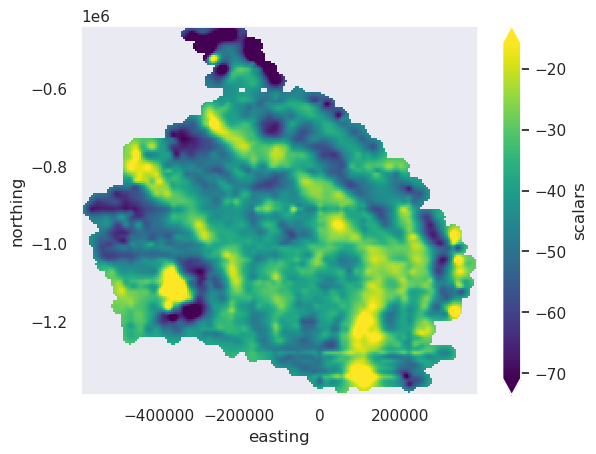

In [7]:
# Define grid coordinates
region = vd.pad_region(vd.get_region(coords), 20e3)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3,  # upward continue to 1km
)

grid_before_level = eqs.grid(grid_coords)

masked_before_level = vd.distance_mask(
    (coords[0], coords[1]), maxdist=20e3, grid=grid_before_level
)
masked_before_level = masked_before_level.reset_coords(names="upward").scalars
masked_before_level.plot(robust=True)

# Exclude certain intersections

In [8]:
# exclude based on max distance to real points
cutoff_dist = 20e3

prior_len = len(inters)

inters2 = inters[inters.max_dist < cutoff_dist].copy()
print(
    f"removed {prior_len - len(inters2)} intersections points which were",
    f"further than {int(cutoff_dist/1000)}km from nearest data point",
)

removed 6 intersections points which were further than 20km from nearest data point


In [9]:
exclude_inds = []

ind = inters2[(inters2.line1 == 470) & (inters2.line2 == 1070)].index.values
exclude_inds.extend(ind)

# ind = inters2[(inters2.line1==1120) | (inters2.line2==1120)].index.values
# exclude_inds.extend(ind)

# drop intersections from inters
inters2.drop(index=exclude_inds, inplace=True, errors="ignore")

print(f"removed {len(exclude_inds)} intersection")
print(f"{len(inters2)} intersections remaining")

removed 1 intersection
427 intersections remaining


In [10]:
# Only keep intersection rows in gravity df if they are in ther intersection df
inds_to_keep = []
for i, row in inters2.iterrows():
    line1 = row.line1
    line2 = row.line2

    ind = rosetta_UC[
        (rosetta_UC.is_intersection)
        & ((rosetta_UC.line == line1) & (rosetta_UC.intersecting_line == line2))
        | ((rosetta_UC.line == line2) & (rosetta_UC.intersecting_line == line1))
    ].index.values
    inds_to_keep.extend(ind)

print(
    f"removed {len(rosetta_UC[rosetta_UC.is_intersection])-len(inds_to_keep)} intersections"
)

inds_to_keep.extend(rosetta_UC[~rosetta_UC.is_intersection].index.values)

# drop intersection row from gravity df
df = rosetta_UC[rosetta_UC.index.isin(inds_to_keep)]

print(f"{len(df[df.is_intersection])} intersections remaining")
print(f"{len(df)} total points remaining")

removed 14 intersections
854 intersections remaining
37818 total points remaining


In [ ]:
# # comletely delete line
# rosetta_UC.drop(index=rosetta_UC[rosetta_UC.line==1120].index, inplace=True, errors="ignore")
# rosetta_UC.line.unique()

In [11]:
print(f"Mistie RMS before dropping intersections: {utils.RMSE(inters.mistie_after_UC)}")
inters = inters2.copy()
rosetta_UC = df.copy()
print(f"Mistie RMS after dropping intersections: {utils.RMSE(inters.mistie_after_UC)}")
inters.sort_values(by="mistie_after_UC").head()

Mistie RMS before dropping intersections: 5.139485861919639
Mistie RMS after dropping intersections: 4.882721289166959


,line1,line2,max_dist,easting,northing,dist_along_line1,dist_along_line2,line1_value,line2_value,mistie_before_UC,mistie_after_UC,geometry
430,900.0,1120.0,43.162037,221717.580801,-1.340639e+06,298.011709,488765.962690,-80.718939,-57.300974,-32.073100,-23.417965,POINT (221717.58080 -1340638.59959)
219,570.0,1140.0,21.841974,331789.980110,-1.010405e+06,878331.819658,164457.167883,-51.805991,-34.242501,-16.787859,-17.563490,POINT (331789.98011 -1010404.82335)
139,470.0,1080.0,23.011564,1628.803221,-9.105217e+05,221124.697059,444319.097936,-42.883604,-30.470989,-12.605192,-12.412614,POINT (1628.80322 -910521.68594)
131,450.0,1120.0,43.367139,221715.809338,-8.904958e+05,778264.612225,38623.149362,-45.124084,-34.386243,-10.915196,-10.737841,POINT (221715.80934 -890495.77861)
132,470.0,1000.0,42.635517,-470170.177588,-9.105511e+05,692923.678782,150764.786215,-69.348869,-60.137446,-8.818665,-9.211423,POINT (-470170.17759 -910551.05156)


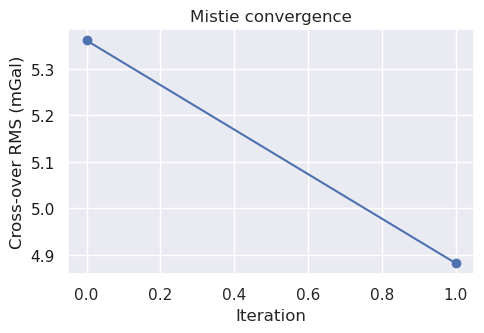

In [12]:
grav.plot_levelling_convergence(
    rosetta_UC,
    mistie_prefix="mistie",
    title="Mistie convergence",
    # logy=True,
)

# Alternative between lines and ties

## 0th order

Starting RMSE mistie: 4.882721289166959 mGal
RMSE mistie after iteration 1: L -> T: 4.643214130239466 mGal
RMS correction to lines: 1.5424533236927758 mGal
RMSE mistie after iteration 1: T -> L: 4.521414626639262 mGal
RMS correction to ties: 1.090368629081498 mGal
RMSE mistie after iteration 2: L -> T: 4.515752818353361 mGal
RMS correction to lines: 0.22536506079727267 mGal
RMSE mistie after iteration 2: T -> L: 4.515358119515755 mGal
RMS correction to ties: 0.06301598655104161 mGal
RMSE mistie after iteration 3: L -> T: 4.515324430947248 mGal
RMS correction to lines: 0.017567339051964618 mGal
RMSE mistie after iteration 3: T -> L: 4.515321196414684 mGal
RMS correction to ties: 0.0058847191639618225 mGal
RMSE mistie after iteration 4: L -> T: 4.5153208602805535 mGal
RMS correction to lines: 0.0017682623199972466 mGal
RMSE mistie after iteration 4: T -> L: 4.5153208231844655 mGal
RMS correction to ties: 0.0006360395103044048 mGal
RMSE mistie after iteration 5: L -> T: 4.515320818872238 

,easting,northing,line,LATITUDE,LONGITUDE,unixtime,Height,FAG_levelled,dist_along_line,mistie_before_UC,...,mistie_trend0_3t,levelled_data_trend0_4l,mistie_trend0_4l,levelled_data_trend0_4t,mistie_trend0_4t,levelled_data_trend0_5l,mistie_trend0_5l,levelled_data_trend0_5t,mistie_trend0_5t,total_level_corr
0,-323017.301127,-4.604725e+05,20.0,-84.827798,-144.950697,1.480724e+09,1000.0,-79.585185,124715.592483,NaN,...,NaN,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN,0.000000
1,-321997.009961,-4.604783e+05,20.0,-84.833130,-145.036205,1.480724e+09,1000.0,-79.477289,123695.301723,NaN,...,NaN,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN,0.000000
2,-320976.263358,-4.604806e+05,20.0,-84.838479,-145.121727,1.480724e+09,1000.0,-79.280965,122674.555360,NaN,...,NaN,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN,0.000000
3,-319954.356535,-4.604793e+05,20.0,-84.843849,-145.207317,1.480724e+09,1000.0,-79.010975,121652.648406,NaN,...,NaN,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN,0.000000
4,-318974.502480,-4.604769e+05,20.0,-84.848997,-145.289477,1.480724e+09,1000.0,-78.693828,120672.794120,NaN,...,NaN,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37827,331826.687432,-1.100608e+06,1140.0,NaN,NaN,NaN,1000.0,-41.511223,74254.443110,5.295003,...,3.953231,-41.584672,3.955045,-41.582946,3.953319,-41.582946,3.953508,-41.582744,3.953307,-0.589405
37828,331826.259411,-1.070505e+06,1140.0,NaN,NaN,NaN,1000.0,-31.341988,104357.487900,1.763079,...,1.468759,-31.972955,1.470590,-31.971229,1.468864,-31.971229,1.469076,-31.971027,1.468874,-0.589405
37829,331840.937091,-1.050564e+06,1140.0,NaN,NaN,NaN,1000.0,-32.080697,124298.192629,1.681957,...,2.368205,-32.221899,2.370036,-32.220174,2.368310,-32.220174,2.368521,-32.219972,2.368320,-0.589405
37830,331832.763929,-1.040655e+06,1140.0,NaN,NaN,NaN,1000.0,-33.006908,134206.942814,4.427681,...,4.290984,-33.157338,4.292815,-33.155612,4.291089,-33.155612,4.291300,-33.155411,4.291099,-0.589405


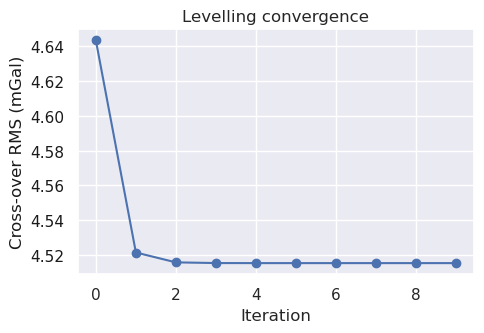

In [13]:
# perform iterative leveling, alternating between flight and tie lines
rosetta_UC_levelled_trend0, inters_levelled_trend0 = grav.iterative_levelling_alternate(
    inters,
    rosetta_UC,
    tie_line_names=rosetta_UC.line[rosetta_UC.line >= 1000].unique(),
    flight_line_names=rosetta_UC.line[rosetta_UC.line < 1000].unique(),
    degree=0,
    starting_mistie_col="mistie_after_UC",
    starting_data_col="up_cont_grav",
    iterations=5,
    # plot_iterations=True,
    # plot_results=True,
    plot_convergence=True,
)

final_mistie_col_trend0 = list(rosetta_UC_levelled_trend0.columns)[-1]
final_data_col_trend0 = list(rosetta_UC_levelled_trend0.columns)[-2]

rosetta_UC_levelled_trend0["total_level_corr"] = (
    rosetta_UC_levelled_trend0[final_data_col_trend0]
    - rosetta_UC_levelled_trend0.up_cont_grav
)

rosetta_UC_levelled_trend0

## 1st order

Starting RMSE mistie: 4.515320818345753 mGal
RMSE mistie after iteration 1: L -> T: 4.000179946497737 mGal
RMS correction to lines: 2.090544979831053 mGal
RMSE mistie after iteration 1: T -> L: 3.792749207545955 mGal
RMS correction to ties: 1.6760087828609465 mGal
RMSE mistie after iteration 2: L -> T: 3.7370613283180227 mGal
RMS correction to lines: 0.7612372785682684 mGal
RMSE mistie after iteration 2: T -> L: 3.7169162982210815 mGal
RMS correction to ties: 0.5362340906789589 mGal
RMSE mistie after iteration 3: L -> T: 3.708410158739392 mGal
RMS correction to lines: 0.29109783056828886 mGal
RMSE mistie after iteration 3: T -> L: 3.7044975552547696 mGal
RMS correction to ties: 0.2187206942380999 mGal
RMSE mistie after iteration 4: L -> T: 3.7025895389223322 mGal
RMS correction to lines: 0.1348879582702283 mGal
RMSE mistie after iteration 4: T -> L: 3.7016139339563225 mGal
RMS correction to ties: 0.09992837151817378 mGal
RMSE mistie after iteration 5: L -> T: 3.701094275416042 mGal
RMS

,easting,northing,line,LATITUDE,LONGITUDE,unixtime,Height,FAG_levelled,dist_along_line,mistie_before_UC,...,levelled_data_trend1_3t,mistie_trend1_3t,levelled_data_trend1_4l,mistie_trend1_4l,levelled_data_trend1_4t,mistie_trend1_4t,levelled_data_trend1_5l,mistie_trend1_5l,levelled_data_trend1_5t,mistie_trend1_5t
0,-323017.301127,-4.604725e+05,20.0,-84.827798,-144.950697,1.480724e+09,1000.0,-79.585185,124715.592483,NaN,...,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN
1,-321997.009961,-4.604783e+05,20.0,-84.833130,-145.036205,1.480724e+09,1000.0,-79.477289,123695.301723,NaN,...,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN
2,-320976.263358,-4.604806e+05,20.0,-84.838479,-145.121727,1.480724e+09,1000.0,-79.280965,122674.555360,NaN,...,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN
3,-319954.356535,-4.604793e+05,20.0,-84.843849,-145.207317,1.480724e+09,1000.0,-79.010975,121652.648406,NaN,...,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN
4,-318974.502480,-4.604769e+05,20.0,-84.848997,-145.289477,1.480724e+09,1000.0,-78.693828,120672.794120,NaN,...,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37827,331826.687432,-1.100608e+06,1140.0,NaN,NaN,NaN,1000.0,-41.511223,74254.443110,5.295003,...,-39.032981,3.059383,-39.032981,3.004287,-39.065003,3.036310,-39.065003,2.967879,-39.114695,3.017571
37828,331826.259411,-1.070505e+06,1140.0,NaN,NaN,NaN,1000.0,-31.341988,104357.487900,1.763079,...,-34.006574,-4.724178,-34.006574,-4.898049,-34.178389,-4.726233,-34.178389,-4.822969,-34.276120,-4.725238
37829,331840.937091,-1.050564e+06,1140.0,NaN,NaN,NaN,1000.0,-32.080697,124298.192629,1.681957,...,-37.292896,3.426631,-37.292896,3.162328,-37.557312,3.426744,-37.557312,3.298263,-37.686864,3.427816
37830,331832.763929,-1.040655e+06,1140.0,NaN,NaN,NaN,1000.0,-33.006908,134206.942814,4.427681,...,-39.737640,5.391567,-39.737640,5.082465,-40.048070,5.392895,-40.048070,5.248714,-40.193435,5.394079


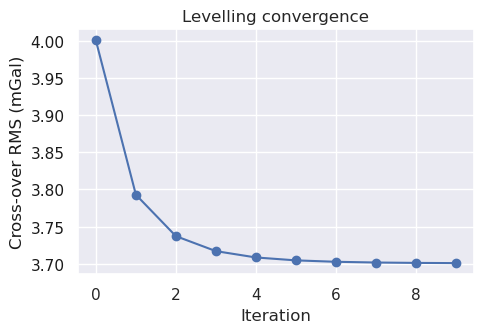

In [14]:
# perform iterative leveling, alternating between flight and tie lines
rosetta_UC_levelled_trend1, inters_levelled_trend1 = grav.iterative_levelling_alternate(
    inters_levelled_trend0,
    rosetta_UC_levelled_trend0,
    tie_line_names=rosetta_UC_levelled_trend0.line[
        rosetta_UC_levelled_trend0.line >= 1000
    ].unique(),
    flight_line_names=rosetta_UC_levelled_trend0.line[
        rosetta_UC_levelled_trend0.line < 1000
    ].unique(),
    degree=1,
    starting_mistie_col=final_mistie_col_trend0,
    starting_data_col=final_data_col_trend0,
    iterations=5,
    # plot_iterations=True,
    # plot_results=True,
    plot_convergence=True,
)

final_mistie_col_trend1 = list(rosetta_UC_levelled_trend1.columns)[-1]
final_data_col_trend1 = list(rosetta_UC_levelled_trend1.columns)[-2]

rosetta_UC_levelled_trend1["total_level_corr"] = (
    rosetta_UC_levelled_trend1[final_data_col_trend1]
    - rosetta_UC_levelled_trend1.up_cont_grav
)

rosetta_UC_levelled_trend1

In [15]:
eqs = hm.EquivalentSources(damping=1e2, depth=10e3, block_size=2e3)

coords = (
    rosetta_UC_levelled_trend1.easting,
    rosetta_UC_levelled_trend1.northing,
    np.ones_like(rosetta_UC_levelled_trend1.northing) * 1e3,
)

data = rosetta_UC_levelled_trend1[final_data_col_trend1]

eqs.fit(coords, data)

EquivalentSources(block_size=2000.0, damping=100.0, depth=10000.0)

In [16]:
# Define grid coordinates
region = vd.pad_region(vd.get_region(coords), 20e3)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3,  # upward continue to 1km
)

grid_alt_trend1 = eqs.grid(grid_coords)

masked_alt_trend1 = vd.distance_mask(
    (coords[0], coords[1]), maxdist=20e3, grid=grid_alt_trend1
)
masked_alt_trend1 = masked_alt_trend1.reset_coords(names="upward").scalars

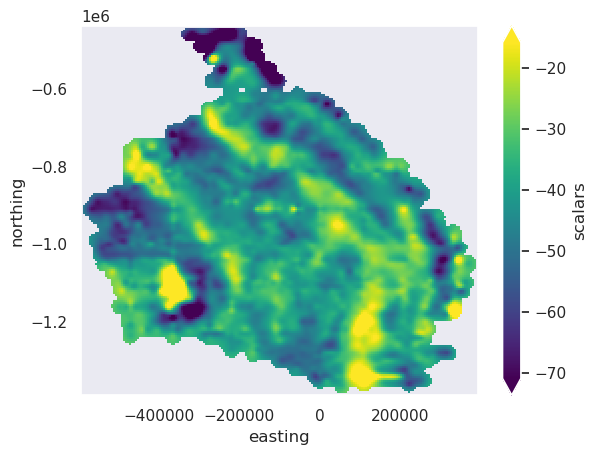

In [17]:
masked_alt_trend1.plot(robust=True)

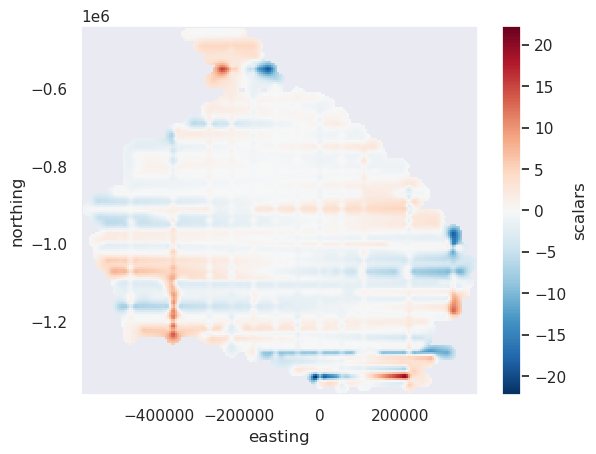

In [18]:
(masked_alt_trend1 - masked_before_level).plot()

## 2nd order

Starting RMSE mistie: 3.700807592810042 mGal
RMSE mistie after iteration 1: L -> T: 3.4005178362281243 mGal
RMS correction to lines: 1.8132034943861763 mGal
RMSE mistie after iteration 1: T -> L: 3.304578972009073 mGal
RMS correction to ties: 1.077741943320011 mGal
RMSE mistie after iteration 2: L -> T: 3.273997227153093 mGal
RMS correction to lines: 0.7010032430257367 mGal
RMSE mistie after iteration 2: T -> L: 3.2607742027745537 mGal
RMS correction to ties: 0.4964513704213842 mGal
RMSE mistie after iteration 3: L -> T: 3.254325314377739 mGal
RMS correction to lines: 0.26015445309601465 mGal
RMSE mistie after iteration 3: T -> L: 3.2509279629302568 mGal
RMS correction to ties: 0.28033698788708783 mGal
RMSE mistie after iteration 4: L -> T: 3.249018368907532 mGal
RMS correction to lines: 0.12831795897747605 mGal
RMSE mistie after iteration 4: T -> L: 3.2478804726935286 mGal
RMS correction to ties: 0.17059679635705613 mGal
RMSE mistie after iteration 5: L -> T: 3.247165578719895 mGal
RM

,easting,northing,line,LATITUDE,LONGITUDE,unixtime,Height,FAG_levelled,dist_along_line,mistie_before_UC,...,levelled_data_trend2_8t,mistie_trend2_8t,levelled_data_trend2_9l,mistie_trend2_9l,levelled_data_trend2_9t,mistie_trend2_9t,levelled_data_trend2_10l,mistie_trend2_10l,levelled_data_trend2_10t,mistie_trend2_10t
0,-323017.301127,-4.604725e+05,20.0,-84.827798,-144.950697,1.480724e+09,1000.0,-79.585185,124715.592483,NaN,...,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN
1,-321997.009961,-4.604783e+05,20.0,-84.833130,-145.036205,1.480724e+09,1000.0,-79.477289,123695.301723,NaN,...,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN
2,-320976.263358,-4.604806e+05,20.0,-84.838479,-145.121727,1.480724e+09,1000.0,-79.280965,122674.555360,NaN,...,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN
3,-319954.356535,-4.604793e+05,20.0,-84.843849,-145.207317,1.480724e+09,1000.0,-79.010975,121652.648406,NaN,...,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN
4,-318974.502480,-4.604769e+05,20.0,-84.848997,-145.289477,1.480724e+09,1000.0,-78.693828,120672.794120,NaN,...,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37827,331826.687432,-1.100608e+06,1140.0,NaN,NaN,NaN,1000.0,-41.511223,74254.443110,5.295003,...,-39.972408,0.545105,-39.972408,0.521387,-39.999941,0.548920,-39.999941,0.525621,-40.026225,0.551906
37828,331826.259411,-1.070505e+06,1140.0,NaN,NaN,NaN,1000.0,-31.341988,104357.487900,1.763079,...,-32.823500,-4.314474,-32.823500,-4.291528,-32.799571,-4.315457,-32.799571,-4.304954,-32.788299,-4.316227
37829,331840.937091,-1.050564e+06,1140.0,NaN,NaN,NaN,1000.0,-32.080697,124298.192629,1.681957,...,-36.656610,0.965896,-36.656610,0.996802,-36.625084,0.965276,-36.625084,0.983543,-36.606332,0.964791
37830,331832.763929,-1.040655e+06,1140.0,NaN,NaN,NaN,1000.0,-33.006908,134206.942814,4.427681,...,-39.951841,3.298140,-39.951841,3.325203,-39.924392,3.297754,-39.924392,3.314765,-39.907079,3.297453


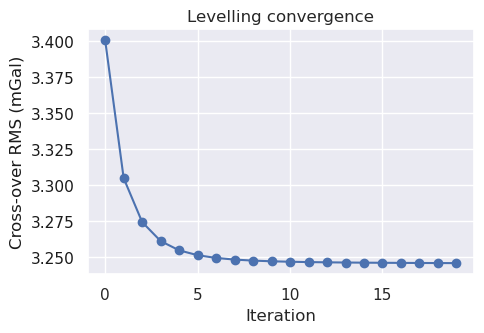

In [19]:
# perform iterative leveling, alternating between flight and tie lines
rosetta_UC_levelled_trend2, inters_levelled_trend2 = grav.iterative_levelling_alternate(
    inters_levelled_trend1,
    rosetta_UC_levelled_trend1,
    tie_line_names=rosetta_UC_levelled_trend1.line[
        rosetta_UC_levelled_trend1.line >= 1000
    ].unique(),
    flight_line_names=rosetta_UC_levelled_trend1.line[
        rosetta_UC_levelled_trend1.line < 1000
    ].unique(),
    degree=2,
    starting_mistie_col=final_mistie_col_trend1,
    starting_data_col=final_data_col_trend1,
    iterations=10,
    # plot_iterations=True,
    # plot_results=True,
    plot_convergence=True,
)

final_mistie_col_trend2 = list(rosetta_UC_levelled_trend2.columns)[-1]
final_data_col_trend2 = list(rosetta_UC_levelled_trend2.columns)[-2]

rosetta_UC_levelled_trend2["total_level_corr"] = (
    rosetta_UC_levelled_trend2[final_data_col_trend2]
    - rosetta_UC_levelled_trend2.up_cont_grav
)

rosetta_UC_levelled_trend2

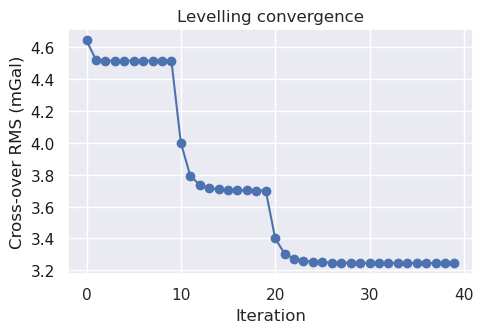

In [20]:
grav.plot_levelling_convergence(
    rosetta_UC_levelled_trend2,
    mistie_prefix="mistie_trend",
    # title = "Mistie convergence",
    # logy=True,
)

In [21]:
# grav.plotly_points(
#     rosetta_UC_levelled_trend2,
#     coord_names=["easting", "northing"],
#     color_col=final_data_col_trend2,
#     hover_cols=[final_data_col_trend2, "Height", "line"],
#     robust=True,
#     # point_size=5,
# )

In [22]:
eqs = hm.EquivalentSources(damping=1e2, depth=10e3, block_size=2e3)

coords = (
    rosetta_UC_levelled_trend2.easting,
    rosetta_UC_levelled_trend2.northing,
    np.ones_like(rosetta_UC_levelled_trend2.northing) * 1e3,
)

data = rosetta_UC_levelled_trend2[final_data_col_trend2]

eqs.fit(coords, data)

EquivalentSources(block_size=2000.0, damping=100.0, depth=10000.0)

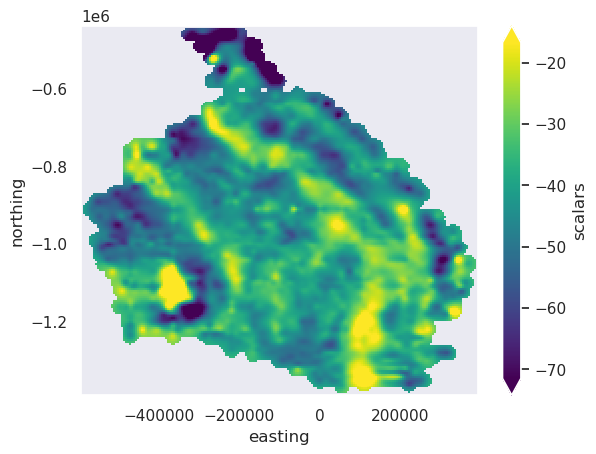

In [23]:
# Define grid coordinates
region = vd.pad_region(vd.get_region(coords), 20e3)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3,  # upward continue to 1km
)

grid_alt_trend2 = eqs.grid(grid_coords)

masked_alt_trend2 = vd.distance_mask(
    (coords[0], coords[1]), maxdist=20e3, grid=grid_alt_trend2
)
masked_alt_trend2 = masked_alt_trend2.reset_coords(names="upward").scalars
masked_alt_trend2.plot(robust=True)

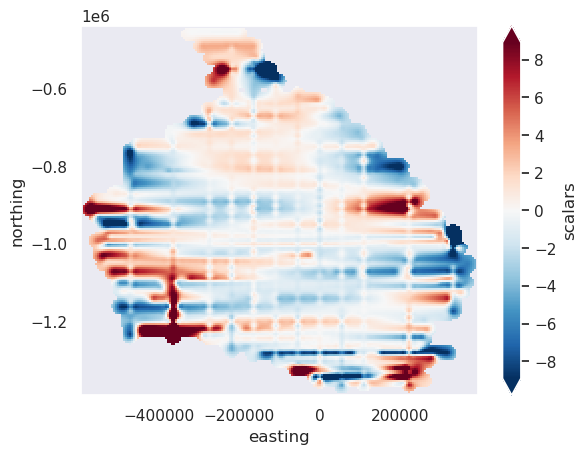

In [24]:
(masked_alt_trend2 - masked_before_level).plot(robust=True)

## Save and load from csv

In [25]:
rosetta_UC_levelled_trend2.to_csv(
    "../../data/ROSETTA_2nd_order_levelled.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
inters_levelled_trend2.to_file(
    "../../data/ROSETTA_2nd_order_levelled_intersections.gpkg",
)

In [26]:
rosetta_UC_levelled_trend2 = pd.read_csv(
    "../../data/ROSETTA_2nd_order_levelled.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inters_levelled_trend2 = gpd.GeoDataFrame.from_file(
    "../../data/ROSETTA_2nd_order_levelled_intersections.gpkg",
)
rosetta_UC_levelled_trend2

,easting,northing,line,LATITUDE,LONGITUDE,unixtime,Height,FAG_levelled,dist_along_line,mistie_before_UC,...,levelled_data_trend2_8t,mistie_trend2_8t,levelled_data_trend2_9l,mistie_trend2_9l,levelled_data_trend2_9t,mistie_trend2_9t,levelled_data_trend2_10l,mistie_trend2_10l,levelled_data_trend2_10t,mistie_trend2_10t
0,-323017.301127,-4.604725e+05,20.0,-84.827798,-144.950697,1.480724e+09,1000.0,-79.585185,124715.592483,NaN,...,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN
1,-321997.009961,-4.604783e+05,20.0,-84.833130,-145.036205,1.480724e+09,1000.0,-79.477289,123695.301723,NaN,...,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN
2,-320976.263358,-4.604806e+05,20.0,-84.838479,-145.121727,1.480724e+09,1000.0,-79.280965,122674.555360,NaN,...,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN
3,-319954.356535,-4.604793e+05,20.0,-84.843849,-145.207317,1.480724e+09,1000.0,-79.010975,121652.648406,NaN,...,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN
4,-318974.502480,-4.604769e+05,20.0,-84.848997,-145.289477,1.480724e+09,1000.0,-78.693828,120672.794120,NaN,...,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37813,331826.687432,-1.100608e+06,1140.0,NaN,NaN,NaN,1000.0,-41.511223,74254.443110,5.295003,...,-39.972408,0.545105,-39.972408,0.521387,-39.999941,0.548920,-39.999941,0.525621,-40.026225,0.551906
37814,331826.259411,-1.070505e+06,1140.0,NaN,NaN,NaN,1000.0,-31.341988,104357.487900,1.763079,...,-32.823500,-4.314474,-32.823500,-4.291528,-32.799571,-4.315457,-32.799571,-4.304954,-32.788299,-4.316227
37815,331840.937091,-1.050564e+06,1140.0,NaN,NaN,NaN,1000.0,-32.080697,124298.192629,1.681957,...,-36.656610,0.965896,-36.656610,0.996802,-36.625084,0.965276,-36.625084,0.983543,-36.606332,0.964791
37816,331832.763929,-1.040655e+06,1140.0,NaN,NaN,NaN,1000.0,-33.006908,134206.942814,4.427681,...,-39.951841,3.298140,-39.951841,3.325203,-39.924392,3.297754,-39.924392,3.314765,-39.907079,3.297453


## 3rd order

Starting RMSE mistie: 3.245414105522874 mGal
RMSE mistie after iteration 1: L -> T: 2.9940527210549837 mGal
RMS correction to lines: 2.2190938410003778 mGal
RMSE mistie after iteration 1: T -> L: 2.9312102674571436 mGal
RMS correction to ties: 2.150387658745611 mGal
RMSE mistie after iteration 2: L -> T: 2.896003116696518 mGal
RMS correction to lines: 0.8174995029381553 mGal
RMSE mistie after iteration 2: T -> L: 2.8722891144474985 mGal
RMS correction to ties: 1.823249452300407 mGal
RMSE mistie after iteration 3: L -> T: 2.8543684496338284 mGal
RMS correction to lines: 0.5189081679488501 mGal
RMSE mistie after iteration 3: T -> L: 2.839798992541782 mGal
RMS correction to ties: 1.6004636940521557 mGal
RMSE mistie after iteration 4: L -> T: 2.8274299547018944 mGal
RMS correction to lines: 0.4036101378263777 mGal
RMSE mistie after iteration 4: T -> L: 2.8166682829200176 mGal
RMS correction to ties: 1.4182379386604138 mGal
RMSE mistie after iteration 5: L -> T: 2.807166825961639 mGal
RMS c

,easting,northing,line,LATITUDE,LONGITUDE,unixtime,Height,FAG_levelled,dist_along_line,mistie_before_UC,...,levelled_data_trend3_8t,mistie_trend3_8t,levelled_data_trend3_9l,mistie_trend3_9l,levelled_data_trend3_9t,mistie_trend3_9t,levelled_data_trend3_10l,mistie_trend3_10l,levelled_data_trend3_10t,mistie_trend3_10t
0,-323017.301127,-4.604725e+05,20.0,-84.827798,-144.950697,1.480724e+09,1000.0,-79.585185,124715.592483,NaN,...,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN,-71.420414,NaN
1,-321997.009961,-4.604783e+05,20.0,-84.833130,-145.036205,1.480724e+09,1000.0,-79.477289,123695.301723,NaN,...,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN,-73.003237,NaN
2,-320976.263358,-4.604806e+05,20.0,-84.838479,-145.121727,1.480724e+09,1000.0,-79.280965,122674.555360,NaN,...,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN,-74.369949,NaN
3,-319954.356535,-4.604793e+05,20.0,-84.843849,-145.207317,1.480724e+09,1000.0,-79.010975,121652.648406,NaN,...,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN,-75.493011,NaN
4,-318974.502480,-4.604769e+05,20.0,-84.848997,-145.289477,1.480724e+09,1000.0,-78.693828,120672.794120,NaN,...,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN,-76.324235,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37813,331826.687432,-1.100608e+06,1140.0,NaN,NaN,NaN,1000.0,-41.511223,74254.443110,5.295003,...,-46.346299,0.320328,-46.346299,-0.134450,-46.763907,0.283157,-46.763907,-0.121151,-47.135012,0.249955
37814,331826.259411,-1.070505e+06,1140.0,NaN,NaN,NaN,1000.0,-31.341988,104357.487900,1.763079,...,-33.360009,0.041129,-33.360009,-0.019590,-33.442676,0.063077,-33.442676,-0.004912,-33.530522,0.082934
37815,331840.937091,-1.050564e+06,1140.0,NaN,NaN,NaN,1000.0,-32.080697,124298.192629,1.681957,...,-29.882153,-0.081286,-29.882153,0.297838,-29.501605,-0.082710,-29.501605,0.234312,-29.183228,-0.084066
37816,331832.763929,-1.040655e+06,1140.0,NaN,NaN,NaN,1000.0,-33.006908,134206.942814,4.427681,...,-31.255866,0.017966,-31.255866,0.497747,-30.765834,0.007715,-30.765834,0.411551,-30.352656,-0.001627


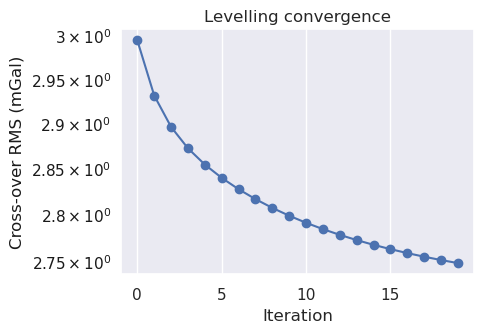

In [27]:
# perform iterative leveling, alternating between flight and tie lines
rosetta_UC_levelled_trend3, inters_levelled_trend3 = grav.iterative_levelling_alternate(
    inters_levelled_trend2,
    rosetta_UC_levelled_trend2,
    tie_line_names=rosetta_UC_levelled_trend2.line[
        rosetta_UC_levelled_trend2.line >= 1000
    ].unique(),
    flight_line_names=rosetta_UC_levelled_trend2.line[
        rosetta_UC_levelled_trend2.line < 1000
    ].unique(),
    degree=3,
    starting_mistie_col=final_mistie_col_trend2,
    starting_data_col=final_data_col_trend2,
    iterations=10,
    # plot_iterations=True,
    # plot_results=True,
    plot_convergence=True,
    logy=True,
)

final_mistie_col_trend3 = list(rosetta_UC_levelled_trend3.columns)[-1]
final_data_col_trend3 = list(rosetta_UC_levelled_trend3.columns)[-2]

rosetta_UC_levelled_trend3["total_level_corr"] = (
    rosetta_UC_levelled_trend3[final_data_col_trend3]
    - rosetta_UC_levelled_trend3.up_cont_grav
)

rosetta_UC_levelled_trend3

In [28]:
eqs = hm.EquivalentSources(damping=1e2, depth=10e3, block_size=2e3)

coords = (
    rosetta_UC_levelled_trend3.easting,
    rosetta_UC_levelled_trend3.northing,
    np.ones_like(rosetta_UC_levelled_trend3.northing) * 1e3,
)

data = rosetta_UC_levelled_trend3[final_data_col_trend3]

eqs.fit(coords, data)

EquivalentSources(block_size=2000.0, damping=100.0, depth=10000.0)

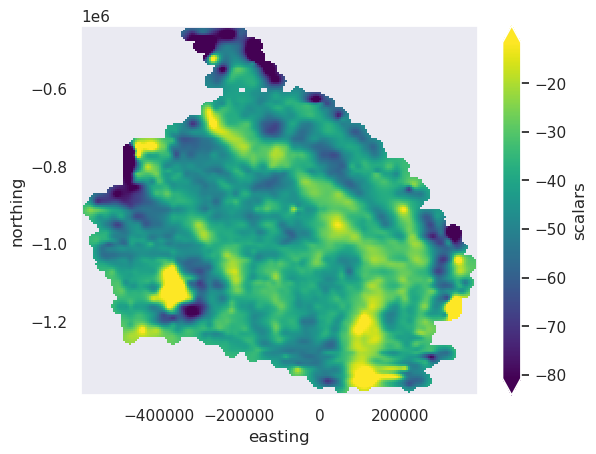

In [29]:
# Define grid coordinates
region = vd.pad_region(vd.get_region(coords), 20e3)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3,  # upward continue to 1km
)

grid_alt_trend3 = eqs.grid(grid_coords)

masked_alt_trend3 = vd.distance_mask(
    (coords[0], coords[1]), maxdist=20e3, grid=grid_alt_trend3
)
masked_alt_trend3 = masked_alt_trend3.reset_coords(names="upward").scalars
masked_alt_trend3.plot(robust=True)

In [ ]:
(masked_alt_trend3 - masked_before_level).plot(robust=True)

In [ ]:
(masked_alt_trend3 - masked_alt_trend2).plot(robust=True)

# Just level lines, then ties
## Level lines to ties

### 0th order levelling
Apply DC-shifts to all lines to minimize mistie values

calculates least-squares trend through intersection points

In [ ]:
# # level an individual line
# line = 1090
# df1 = grav.verde_predict_trend(
#     inters[inters.line2==line],
#     ["easting", "northing", "mistie_after_UC"],
#     rosetta_UC[rosetta_UC.line==line],
#     ["easting", "northing", "levelling_correction"],
#     degree=1,
# )
# df1['levelled'] = df1.up_cont_grav - df1.levelling_correction

# grav.plot_line_and_crosses(
#     df1,
#     y=[
#         "up_cont_grav",
#         "levelled",
#         "levelling_correction",
#         "mistie_after_UC"
#     ],
#     y_axes = [1,1,1,1],
#     plot_inters = [True, False, False, False],
#     marker_sizes=[2,2,2,10]
#     )

In [ ]:
# # level an individual line
# line = 190
# df1 = grav.skl_predict_trend(
#     inters[(inters.line1==line) | (inters.line2==line)],
#     ["dist_along_line1", "mistie_after_UC"],
#     rosetta_UC[rosetta_UC.line==line],
#     ["dist_along_line", "levelling_correction"],
#     degree=1,
# )
# df1['levelled'] = df1.up_cont_grav - df1.levelling_correction

# grav.plot_line_and_crosses(
#     df1,
#     y=[
#         "up_cont_grav",
#         "levelled",
#         "levelling_correction",
#         "mistie_after_UC"
#     ],
#     y_axes = [1,1,1,1],
#     plot_inters = [True, False, False, False],
#     marker_sizes=[2,2,2,10]
#     )

In [ ]:
# # level a group of lines
# rosetta_UC1, inters1 = grav.level_lines(
#     inters,
#     rosetta_UC,
#     lines_to_level = rosetta_UC.line[rosetta_UC.line<1000].unique(),
#     cols_to_fit = "dist_along_line1",
#     cols_to_predict = "dist_along_line",
#     degree=0,
#     data_col = "up_cont_grav",
#     mistie_col = "mistie_before_UC",
#     new_mistie_col = "mistie_trend0_1",
#     levelled_col = "levelled",
#     plot=True,
# )

In [ ]:
# # perform iterative levelling, just moving lines to match ties
# rosetta_trend0, inters_trend0 = grav.iterative_line_levelling(
#     inters,
#     rosetta_UC,
#     flight_line_names=rosetta_UC.line[rosetta_UC.line < 1000].unique(),
#     degree=0,
#     starting_mistie_col="mistie_after_UC",
#     starting_data_col="up_cont_grav",
#     cols_to_fit="dist_along_line1",
#     iterations=3,
#     # plot_iterations=True,
#     # plot_results=True,
#     plot_convergence=True,
# )
# trend0_final_mistie_col = list(rosetta_trend0.columns)[-1]
# trend0_final_data_col = list(rosetta_trend0.columns)[-2]

# print(trend0_final_mistie_col)
# print(trend0_final_data_col)

# rosetta_trend0["total_level_corr"] = (
#     rosetta_trend0[trend0_final_data_col] - rosetta_trend0.up_cont_grav)

# rosetta_trend0.describe()

### 1st order levelling

In [ ]:
# # repeate at a higher order trend
# rosetta_trend1, inters_trend1 = grav.iterative_line_levelling(
#     inters_trend0,
#     rosetta_trend0,
#     flight_line_names=rosetta_trend0.line[rosetta_trend0.line < 1000].unique(),
#     degree=1,
#     starting_mistie_col=trend0_final_mistie_col,
#     starting_data_col=trend0_final_data_col,
#     cols_to_fit="dist_along_line1",
#     iterations=3,
#     # plot_iterations=True,
#     # plot_results=True,
# )
# trend1_final_mistie_col = list(rosetta_trend1.columns)[-1]
# trend1_final_data_col = list(rosetta_trend1.columns)[-2]

# print(trend1_final_mistie_col)
# print(trend1_final_data_col)

# rosetta_trend1["total_level_corr"] = (
#     rosetta_trend1[trend1_final_data_col] - rosetta_trend1.up_cont_grav)

# rosetta_trend1.describe()

In [ ]:
# grav.plotly_points(
#     rosetta_trend1,
#     color_col="total_level_corr",
#     hover_cols=["FAG_levelled", "up_cont_grav", "dif", "line"],
#     robust=True,
#     # point_size=5,
# )

In [ ]:
# grav.plotly_points(
#     rosetta_trend1,
#     color_col=trend1_final_data_col,
#     hover_cols=["FAG_levelled", "up_cont_grav", "dif", "line"],
#     robust=True,
#     # point_size=5,
# )

### 2nd order levelling

In [ ]:
# # repeat at a higher order trend
# rosetta_trend2, inters_trend2 = grav.iterative_line_levelling(
#     inters_trend1,
#     rosetta_trend1,
#     flight_line_names=rosetta_trend1.line[rosetta_trend1.line < 1000].unique(),
#     degree=2,
#     starting_mistie_col=trend1_final_mistie_col,
#     starting_data_col=trend1_final_data_col,
#     cols_to_fit="dist_along_line1",
#     iterations=3,
#     # plot_iterations=True,
#     # plot_results=True,
# )
# trend2_final_mistie_col = list(rosetta_trend2.columns)[-1]
# trend2_final_data_col = list(rosetta_trend2.columns)[-2]

# print(trend2_final_mistie_col)
# print(trend2_final_data_col)

# rosetta_trend2["total_level_corr"] = (
#     rosetta_trend2[trend2_final_data_col] - rosetta_trend2.up_cont_grav)

# rosetta_trend2.describe()

### 3rd order levelling

In [ ]:
# # repeat at a higher order trend
# rosetta_trend3, inters_trend3 = grav.iterative_line_levelling(
#     inters_trend2,
#     rosetta_trend2,
#     flight_line_names=rosetta_trend1.line[rosetta_trend2.line < 1000].unique(),
#     degree=3,
#     starting_mistie_col=trend2_final_mistie_col,
#     starting_data_col=trend2_final_data_col,
#     cols_to_fit="dist_along_line1",
#     iterations=3,
#     # plot_iterations=True,
#     # plot_results=True,
# )
# trend3_final_mistie_col = list(rosetta_trend3.columns)[-1]
# trend3_final_data_col = list(rosetta_trend3.columns)[-2]

# print(trend3_final_mistie_col)
# print(trend3_final_data_col)

# rosetta_trend3["total_level_corr"] = (
#     rosetta_trend3[trend3_final_data_col] - rosetta_trend3.up_cont_grav)

# rosetta_trend3.describe()

In [ ]:
# eqs = hm.EquivalentSources(damping=1e2, depth=10e3, block_size=2e3)

# coords = (
#     rosetta_trend3.easting,
#     rosetta_trend3.northing,
#     np.ones_like(rosetta_trend3.northing) * 1e3,
# )

# data = rosetta_trend3[trend3_final_data_col]

# eqs.fit(coords, data)

In [ ]:
# # Define grid coordinates
# region = vd.pad_region(vd.get_region(coords), 20e3)
# grid_coords = vd.grid_coordinates(
#     region=region,
#     spacing=5e3,
#     extra_coords=1e3,  # upward continue to 1km
# )

# grid_trend3 = eqs.grid(grid_coords)

# masked_trend3 = vd.distance_mask((coords[0], coords[1]), maxdist=20e3, grid=grid_trend3)
# masked_trend3 = masked_trend3.reset_coords(names="upward").scalars
# masked_trend3.plot(robust=True)

In [ ]:
# (masked_trend3-masked_before_level).plot()

## Level ties to lines

### 0th order

In [ ]:
# rosetta_ties_trend0, inters_ties_trend0 = grav.iterative_line_levelling(
#     inters_trend3,
#     rosetta_trend3,
#     flight_line_names=rosetta_trend3.line[rosetta_trend3.line >= 1000].unique(),
#     degree=0,
#     starting_mistie_col=trend3_final_mistie_col,
#     starting_data_col=trend3_final_data_col,
#     iterations=3,
#     mistie_prefix="ties_to_lines_mistie_trend",
#     levelled_data_prefix="ties_to_lines_levelled_data_trend",
#     cols_to_fit="dist_along_line2",
#     # plot_iterations=True,
#     # plot_results=True,
# )
# ties_trend0_final_mistie_col = list(rosetta_ties_trend0.columns)[-1]
# ties_trend0_final_data_col = list(rosetta_ties_trend0.columns)[-2]

# print(ties_trend0_final_mistie_col)
# print(ties_trend0_final_data_col)

# rosetta_ties_trend0["total_level_corr"] = (
#     rosetta_ties_trend0[ties_trend0_final_data_col] - rosetta_ties_trend0.up_cont_grav)

# rosetta_ties_trend0.describe()

In [ ]:
# grav.plotly_points(
#     rosetta_ties_trend0,
#     color_col=ties_trend0_final_data_col,
#     hover_cols=["FAG_levelled", "up_cont_grav", "dif", "Height", "line"],
#     robust=True,
#     # point_size=5,
# )

### 1st order

In [ ]:
# rosetta_ties_trend1, inters_ties_trend1 = grav.iterative_line_levelling(
#     inters_ties_trend0,
#     rosetta_ties_trend0,
#     flight_line_names=rosetta_ties_trend0.line[rosetta_ties_trend0.line >= 1000].unique(),
#     degree=1,
#     starting_mistie_col=ties_trend0_final_mistie_col,
#     starting_data_col=ties_trend0_final_data_col,
#     iterations=3,
#     mistie_prefix="ties_to_lines_mistie_trend",
#     levelled_data_prefix="ties_to_lines_levelled_data_trend",
#     cols_to_fit="dist_along_line2",
#     # plot_iterations=True,
#     # plot_results=True,
# )
# ties_trend1_final_mistie_col = list(rosetta_ties_trend1.columns)[-1]
# ties_trend1_final_data_col = list(rosetta_ties_trend1.columns)[-2]

# rosetta_ties_trend1["total_level_corr"] = (
#     rosetta_ties_trend1[ties_trend1_final_data_col] - rosetta_ties_trend1.up_cont_grav)

# rosetta_ties_trend1.describe()

### 2nd order

In [ ]:
# rosetta_ties_trend2, inters_ties_trend2 = grav.iterative_line_levelling(
#     inters_ties_trend1,
#     rosetta_ties_trend1,
#     flight_line_names=rosetta_ties_trend1.line[rosetta_ties_trend1.line >= 1000].unique(),
#     degree=2,
#     starting_mistie_col=ties_trend1_final_mistie_col,
#     starting_data_col=ties_trend1_final_data_col,
#     iterations=3,
#     mistie_prefix="ties_to_lines_mistie_trend",
#     levelled_data_prefix="ties_to_lines_levelled_data_trend",
#     cols_to_fit="dist_along_line2",
#     # plot_iterations=True,
#     # plot_results=True,
# )
# ties_trend2_final_mistie_col = list(rosetta_ties_trend2.columns)[-1]
# ties_trend2_final_data_col = list(rosetta_ties_trend2.columns)[-2]

# rosetta_ties_trend2["total_level_corr"] = (
#     rosetta_ties_trend2[ties_trend2_final_data_col] - rosetta_ties_trend2.up_cont_grav)

# rosetta_ties_trend2.describe()

In [ ]:
# eqs = hm.EquivalentSources(damping=1e2, depth=10e3, block_size=2e3)

# coords = (
#     rosetta_ties_trend2.easting,
#     rosetta_ties_trend2.northing,
#     np.ones_like(rosetta_ties_trend2.northing) * 1e3,
# )

# data = rosetta_ties_trend2[ties_trend2_final_data_col]

# eqs.fit(coords, data)

In [ ]:
# # Define grid coordinates
# region = vd.pad_region(vd.get_region(coords), 20e3)
# grid_coords = vd.grid_coordinates(
#     region=region,
#     spacing=5e3,
#     extra_coords=1e3,  # upward continue to 1km
# )

# grid_ties_trend2 = eqs.grid(grid_coords)

# masked_ties_trend2 = vd.distance_mask((coords[0], coords[1]), maxdist=20e3, grid=grid_ties_trend2)
# masked_ties_trend2 = masked_ties_trend2.reset_coords(names="upward").scalars
# masked_ties_trend2.plot(robust=True)

In [ ]:
# (masked_ties_trend2 - masked_before_level).plot()

# Extras

In [ ]:
rosetta_UC, inters = grav.level_lines(
    inters,
    rosetta_UC,
    lines_to_level=rosetta_UC.line[rosetta_UC.line > 1000].unique(),
    cols_to_fit="dist_along_line2",
    cols_to_predict="dist_along_line",
    degree=0,
    data_col="levelled",
    mistie_col="mistie_3",
    new_mistie_col="mistie_4",
    levelled_col="levelled2",
    plot=True,
)

In [ ]:
rosetta_UC, inters = grav.level_lines(
    inters,
    rosetta_UC,
    lines_to_level=rosetta_UC.line[rosetta_UC.line < 1000].unique(),
    cols_to_fit="dist_along_line1",
    cols_to_predict="dist_along_line",
    degree=0,
    data_col="levelled2",
    mistie_col="mistie_4",
    new_mistie_col="mistie_5",
    levelled_col="levelled3",
    plot=True,
)

In [ ]:
# iterate through the E-W lines

rosetta_UC["levelled"] = np.nan

for line in rosetta_UC[rosetta_UC.line < 1000].line.unique():
    df = rosetta_UC[rosetta_UC.line == line].copy()

    # fit a polynomial trend through the misties values
    ints = inters[inters.line1 == line]
    coords = (ints.geometry.x, ints.geometry.y)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Under-determined problem")
        try:
            trend = vd.Trend(degree=0).fit(coords, ints.mistie_2)
            # predict the trend on the line data
            df["trend"] = trend.predict((df.easting, df.northing))
        except ValueError:
            print(f"Issue with line {line}")
            df["trend"] = 0

    # remove the trend from the gravity
    values = df.up_cont_grav - df.trend

    rosetta_UC.loc[rosetta_UC.line == line, "levelled"] = values

for line in rosetta_UC[rosetta_UC.line >= 1000].line.unique():
    rosetta_UC.loc[rosetta_UC.line == line, "levelled"] = rosetta_UC.loc[
        rosetta_UC.line == line, "up_cont_grav"
    ]

rosetta_UC["levelling_change"] = rosetta_UC.up_cont_grav - rosetta_UC.levelled

In [ ]:
print(f"Previous mistie RMSE: {utils.RMSE(inters.mistie_2)}")
inters = grav.calculate_misties(
    inters,
    rosetta_UC,
    data_col="levelled",
    mistie_name="mistie_3",
    # plot=True,
    robust=False,
)
inters.sort_values(by="mistie_3")

grav.plotly_points(rosetta_UC, color_col="up_cont_grav", point_size=2)
grav.plotly_points(rosetta_UC, color_col="levelled", point_size=2)
grav.plotly_points(rosetta_UC, color_col="levelling_change", point_size=2)
grav.plotly_points(inters, color_col="mistie_2", point_size=4)
grav.plotly_points(inters, color_col="mistie_3", point_size=4)

In [ ]:
# fit a polynomial trend through the misties
coords = (inters.geometry.x, inters.geometry.y)
trend = vd.Trend(degree=20).fit(coords, inters.mistie_2)

# predict the trend on the intersection points
inters["trend"] = trend.predict(coords)

# remove the trend from the misties
inters["residual"] = inters.mistie_2 - inters.trend

print(utils.RMSE(inters.mistie_2), inters.mistie_2.mean())
print(utils.RMSE(inters.residual), inters.residual.mean())

grav.plotly_points(rosetta_UC, color_col="up_cont_grav", point_size=2)
grav.plotly_points(inters, color_col="mistie_2", point_size=4)
grav.plotly_points(inters, color_col="trend", point_size=4)
grav.plotly_points(inters, color_col="residual", point_size=4)

In [ ]:
# apply correction to the line data

# fit a polynomial trend to the crossover misties
trend = vd.Trend(degree=2).fit(coords, inters.mistie_2)

# predict that trend on the flight line datapoints
rosetta_UC["trend"] = trend.predict((rosetta_UC.easting, rosetta_UC.northing))

# remove the trend from the data
rosetta_UC["levelled"] = rosetta_UC.up_cont_grav - rosetta_UC.trend

grav.plotly_points(
    rosetta_UC,
    color_col="up_cont_grav",
    point_size=2,
    hover_cols=["up_cont_grav", "levelled", "trend"],
)
grav.plotly_points(
    rosetta_UC,
    color_col="trend",
    point_size=2,
    hover_cols=["up_cont_grav", "levelled", "trend"],
)
grav.plotly_points(
    rosetta_UC,
    color_col="levelled",
    point_size=2,
    hover_cols=["up_cont_grav", "levelled", "trend"],
)

In [ ]:
inters.drop(columns=["line1_value", "line2_value"], inplace=True)
inters

In [ ]:
print(f"Previous mistie RMSE: {utils.RMSE(inters.mistie_2)}")
inters = grav.calculate_misties(
    inters,
    rosetta_UC,
    data_col="levelled",
    mistie_name="mistie_3",
    plot=True,
    robust=False,
)
inters.sort_values(by="mistie_3")

## 1st order levelling
Tilt lines to minimize misfit values